# Supervised Auto-Classification of Salesforce Help Documentation
**Thomas Bohn**   --   **2024-10-10**

A report focused on modeling tags (categorization) for Salesforce help documentation focused on the application data source scrapin, application of natural language processing (NLP), supervised learning algorithms, and an application of the process in an automated fashion.

--  [Main Report](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/main/auto_classifying_salesforce_cloud_documentation.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification)  --  [Presentation Slides](TBD)  --  [Presentation Video](TBD) --

# 1.&nbsp;Introduction

**Background**
...

**Data Source**
...


**Labels (Categories)**
...

**Overview of Observations**
...

**Objective**
...

**Report Overview**
...

## Python Libraries

The following python libraries are used in this notebook.

In [ ]:
# File system manangement
import time, datetime, psutil, os

# Data manipulation
import numpy as np
import pandas as pd
import math

# Install text storage and manipulation
import re
import json
import pickle
import textwrap

##################################

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# NLP
import string, re, nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from string import punctuation
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
!pip install num2words
from num2words import num2words
!pip install pyspellchecker
from spellchecker import SpellChecker
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Global Variables

The following are global variables referenced in this notebook.

In [ ]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive. Two data sources (Sales and Service cloud documentation) are merged, cleansed, and prepared for analysis. After merging, the dataset is consolidated into a single table with key columns like 'aria-level', 'title', and 'text', which is used throughout the project.

## About the Scrapping Process

## Import the Data

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path_root = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5506 Data Mining Presentation/data'
file_path_sales   = file_path_root + '/sales_core_df.pickle'
file_path_service = file_path_root + '/service_cloud_df.pickle'


# Load the Service Data From Pickle
with open(file_path_service, 'rb') as f:
  data_service = pickle.load(f)
# Load the Sales Data From Pickle
with open(file_path_sales, 'rb') as f:
  data_sales = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preview the Data Sources
display(data_service.head(1))
display(data_sales.head(1))

,index,aria-level,title,id,href,parent,l0_id,l1_id,l2_id,l3_id,...,l1_title,l2_title,l3_title,l4_title,l5_title,l6_title,l7_title,l8_title,url,text
0,0,0,Service Cloud,service_cloud_leaf,/s/articleView?id=sf.service_cloud.htm&languag...,None,service_cloud_leaf,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Service Cloud Give your customers the informat...


## Data Preparation

In [ ]:
# Find the set of different columns between the two DataFrames
different_columns = set(data_sales.columns) ^ set(data_service.columns)

print("Columns to dropped from tables:", list(different_columns))

# Drop the columns in the difference from both DataFrames
data_sales = data_sales.drop(columns=list(different_columns.intersection(set(data_sales.columns))))
data_service = data_service.drop(columns=list(different_columns.intersection(set(data_service.columns))))

print("Drop Completed.")

Columns to dropped from tables: ['l8_title', 'l8_id']
Drop Completed.


In [ ]:
# Union the 2 tables together to make a single table of data
if list(data_sales.columns) == list(data_service.columns):
  # Merge the DataFrames
  data_merged = pd.concat([data_sales, data_service], ignore_index=True)

  # Specify the columns to keep
  columns_to_keep = ['aria-level', 'title', 'id', 'l0_id', 'l1_id',
                     'l2_id', 'l0_title', 'l1_title', 'l2_title', 'url', 'text']

  # Subset the DataFrame to keep only the specified columns
  data_merged = data_merged[columns_to_keep]

  # Summary of the shape of the data
  print(pd.Series({"Memory usage": "{:.2f} MB".format(data_merged.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_merged.shape)}).to_string())

  # Print the DataFrame to the screen
  print("Columns in table:", list(data_merged.columns))
else:
  print("The columns in the two DataFrames are not the same. Cannot merge.")

Memory usage        0.13 MB
Dataset shape    (1498, 11)
Columns in table: ['aria-level', 'title', 'id', 'l0_id', 'l1_id', 'l2_id', 'l0_title', 'l1_title', 'l2_title', 'url', 'text']


In [ ]:
#Example of the table created
print("Example of the table created:\n")
display(data_merged.head(3))

,aria-level,title,id,l0_id,l1_id,l2_id,l0_title,l1_title,l2_title,url,text
0,0,Sales Cloud Basics,sales_core_leaf,sales_core_leaf,NaN,NaN,Sales Cloud Basics,NaN,NaN,https://help.salesforce.com/s/articleView?id=s...,Sales Cloud Basics The Sales Cloud provides ev...
1,1,"Learn About, Implement, and Optimize Sales Clo...",sales_core_basics_leaf,sales_core_leaf,sales_core_basics_leaf,NaN,Sales Cloud Basics,"Learn About, Implement, and Optimize Sales Clo...",NaN,https://help.salesforce.com/s/articleView?id=s...,"Learn About, Implement, and Optimize Sales Clo..."
2,1,"See an Overview of Metrics, Goals, Suggestions...",sales_core_seller_home_leaf,sales_core_leaf,sales_core_seller_home_leaf,NaN,Sales Cloud Basics,"See an Overview of Metrics, Goals, Suggestions...",NaN,https://help.salesforce.com/s/articleView?id=s...,"See an Overview of Metrics, Goals, Suggestions..."


In [ ]:
# Example of the text from the article
example_text = data_merged['text'].iloc[100]
# Print to Screen
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Length of Text: 901 

Manage Leads View, update, and convert leads as you build your pipeline. Lead Intelligence View View
lead activity and engagement metrics, see insights, take action, and update records all in one place
in the Lead Intelligence View. Leads List View Home Click the Leads tab to display the leads list
view home page or the Lead Intelligence View. Display and Edit Leads Display, edit leads details,
and share leads. Converting Leads After you qualify your leads, convert them to contacts, accounts,
and opportunities. Merge Duplicate Leads Keep your records clean and free of duplicates so you can
reach more customers and maintain better relationships with them. Reassign Leads from a Queue
Accepting leads from a queue is an easy way to reassign leads to yourself. Lead Sharing in
Salesforce Classic Extend sharing privileges beyond the basic sharing model for your own data on a
lead-by-lead basis.


## Address Missing Values

In [ ]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data_merged) - len(data_merged.dropna()),
                 "Number of duplicate observations": data_merged.duplicated().sum()}).to_string())

Number of observations with missing values    26
Number of duplicate observations               2


In [ ]:
# Dropping observations with missing valuesd
data_merged.dropna(inplace = True)
# Dropping duplicate observations
data_merged.drop_duplicates(inplace = True)
# Resetting index
data_merged.reset_index(drop = True, inplace = True)

In [ ]:
# Group the data by l0_id and count the number of records
summary_table_l0 = data_merged.groupby(['l0_id'])['id'].count().reset_index(name='record_count')

# Create a table with a count of each unique label for each group
for col in ['l0_id', 'l1_id', 'l2_id']:
  summary_table_l0 = pd.merge(summary_table_l0,
                           data_merged.groupby(['l0_id'])[col].nunique().reset_index(name=f'{col}_label_count'),
                           on=['l0_id'], how='left')

# Display the Summary Table
summary_table_l0

,l0_id,record_count,l0_id_label_count,l1_id_label_count,l2_id_label_count
0,sales_core_leaf,646,1,7,33
1,service_cloud_leaf,824,1,5,29


In [ ]:
# Group by l0_id and l1_id and count the number of records in each group
summary_table = data_merged.groupby(['l0_id', 'l1_id']).size().reset_index(name='record_count')

# Display the Summary Table
summary_table

,l0_id,l1_id,record_count
0,sales_core_leaf,sales_core_artificial_intelligence_parent_leaf,5
1,sales_core_leaf,sales_core_bring_in_leads_leaf,133
2,sales_core_leaf,sales_core_legacy_features_leaf,11
3,sales_core_leaf,sales_core_manage_accounts_contacts_leaf,99
4,sales_core_leaf,sales_core_manage_sales_team_leaf,275
5,sales_core_leaf,sales_core_salesforce_maps_lite_leaf,3
6,sales_core_leaf,sales_core_turn_opptys_into_deals_leaf,120
7,service_cloud_leaf,support_admins_intro_leaf,187
8,service_cloud_leaf,support_deflection_leaf,192
9,service_cloud_leaf,support_metrics_leaf,124


## Data Scoping Functions

In [ ]:
# Function to invert a dictionary (swap keys and values)
def invert_dictionary(dictionary):
  # Check if the input is a dictionary, return None if it's not
  if not isinstance(dictionary, dict):
    return None

  inverted_dictionary = {}

  # Iterate through the key-value pairs in the original dictionary
  for key, value in dictionary.items():
    # If the value is not already a key in the inverted dictionary, add it
    if value not in inverted_dictionary:
      inverted_dictionary[value] = key
    else:
      # If the value already exists as a key in the inverted dictionary, check if it's a list
      if isinstance(inverted_dictionary[value], list):
        inverted_dictionary[value].append(key)
      else:
        inverted_dictionary[value] = [inverted_dictionary[value], key]

  return inverted_dictionary

# Function to replace labels in a list based on a label dictionary
def replace_labels(labels, label_dict):
  new_labels = []
  # Iterate through each label in the input list
  for label in labels:
    # If the label exists in the label dictionary, append the replacement label
    if label in label_dict:
      new_labels.append(label_dict[label])
    else:
      new_labels.append(label)

  return new_labels

In [ ]:
# Function to use a label to define the scope of the data for use
def scope_data(data_input, label_col):

  # Specify the columns to keep
  columns_to_keep = ['id', label_col, 'text', 'title', 'url']

  # Subset the DataFrame to keep only the specified columns
  data = data_input[columns_to_keep]

  #rename the column lo_id to label
  data = data.rename(columns={label_col: 'label'})

  #Remove any labels that do not have data coverage
  threshold = 4
  label_counts = data['label'].value_counts()
  labels_to_drop = label_counts[label_counts <= threshold].index.tolist()

  if labels_to_drop:
    print(f"Dropping records belonging to labels with {threshold} or fewer records: {labels_to_drop}")
    data = data[~data['label'].isin(labels_to_drop)]
  else:
    print(f"No labels with {threshold} or fewer records found.")

  # Automatically encoding of labels
  label_dict = {}
  unique_labels = data['label'].unique()
  for i, label in enumerate(unique_labels):
    label_dict[label] = i
  # Create the inverse dictionary
  inverted_label_dict = invert_dictionary(label_dict)

  # Replace the labels with the encoded values
  data.replace({'label': label_dict}, inplace = True)

  # Summary of the shape of the data
  print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                  "Dataset shape": "{}".format(data.shape)}).to_string())

  # Print the DataFrame to the screen
  print("Columns in table:", list(data.columns))

  return data, label_dict, inverted_label_dict

In [ ]:
# Create a dictionary to store the data for each label
def create_data_by_label(data, label_col):
  data_by_label = {}
  # Iterate over the unique labels
  for label in data['label'].unique():
      # Subset the data for the current label
      data_by_label[label] = data[data['label'] == label]

  print("Size of the data by label dictionary:", len(data_by_label), "\n")

  return data_by_label

## Scope the Label and Text for Analysis

In [ ]:
# Select the scope of data and label to target
scope = 'l0_id'
data, label_dict, inverted_label_dict = scope_data(data_merged, label_col = scope)
print("label_dictionary:", label_dict, "\n")

# Create the data by label structure
data_by_label = create_data_by_label(data, 'label')

# Display the scoped dataframe
display(data.head(3))

Memory usage       0.06 MB
Dataset shape    (1470, 5)
Columns in table: ['id', 'label', 'text', 'title', 'url']
label_dictionary: {'sales_core_leaf': 0, 'service_cloud_leaf': 1} 

Size of the data by label dictionary: 2 



<ipython-input-102-d490ebb4e9de>:21: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,id,label,text,title,url
0,campaigns_def_leaf,0,Get to Know Salesforce Campaigns Many cross-fu...,Get to Know Salesforce Campaigns,https://help.salesforce.com/s/articleView?id=s...
1,campaigns_tour_leaf,0,Tour the Campaigns Object To get familiar with...,Tour the Campaigns Object,https://help.salesforce.com/s/articleView?id=s...
2,campaigns_use_cases_leaf,0,How Campaigns Can Help You can use Salesforce ...,How Campaigns Can Help,https://help.salesforce.com/s/articleView?id=s...
3,campaigns_use_cases_other_clouds_leaf,0,Use Campaigns with Other Clouds For a more com...,Use Campaigns with Other Clouds,https://help.salesforce.com/s/articleView?id=s...
4,campaigns_hierarchy_leaf,0,Understand Campaign Hierarchy To organize and ...,Understand Campaign Hierarchy,https://help.salesforce.com/s/articleView?id=s...
...,...,...,...,...,...
1465,rules_viewing_escrules_queue_leaf,1,Monitor the Case Escalation Rule Queue When Sa...,Case Escalation Rule Queue,https://help.salesforce.com/s/articleView?id=s...
1466,entitlement_process_queue_leaf,1,Monitor the Entitlement Process Queue When Sal...,Entitlement Process Queue,https://help.salesforce.com/s/articleView?id=s...
1467,monitor_article_automated_actions_leaf,1,Monitor Automated Article Process Actions Sale...,Article Process Actions,https://help.salesforce.com/s/articleView?id=s...
1468,reports_support_crts_leaf,1,Use Custom Report Types to Report on Support A...,Use Custom Report Types,https://help.salesforce.com/s/articleView?id=s...


# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

In [ ]:
# Create a function to print key table details
def quick_table_details (df_name, df, level_of_detail = 10):
  # describe the shape and column summary
  if level_of_detail >= 1:
    print('\n####', df_name, '####')
    num_rows = df.shape[0]
    num_cols = df.shape[1]
    print('number of features (columns) = ' + str(num_cols))
    print('number of observations (rows) = ' + str(num_rows))
    print('----------------------------', '\n')
  # print the datatype counts
  if level_of_detail >= 2:
    print('DataType Counts:')
    display(df.dtypes.value_counts())
    print('----------------------------', '\n')
  # print a full list of column names
  if level_of_detail >= 3:
    print('Columns:')
    print(df.columns)
    print('----------------------------', '\n')
  #  expanded table details
  if level_of_detail >= 4:
    print('Description:')
    display(df.describe(include='all'))
    print('----------------------------', '\n')
    print('Info:')
    display(df.info())
    print('----------------------------', '\n')
  #  table records preview
  if level_of_detail >= 5:
    print('Table Preview:')
    x_records = 3
    display(df.head(x_records))
    print('....')
    display(df.tail(x_records))
    print('----------------------------', '\n')

In [ ]:
# function to count the number of records in each category and stats
def count_field(df, field = 'label'):
    df_cat_count = pd.DataFrame(df[field].value_counts()).reset_index()
    #df_cat_count = df_cat_count.rename(columns={'label': 'Count', 'index': 'Label'})
    df_cat_count = df_cat_count.sort_values(by = ['count'], ascending = False)
    df_cat_count['Pct of Total'] = round(df_cat_count['count'] / df_cat_count['count'].sum(), 2)
    df_cat_count['Pct of Total Text'] = (df_cat_count['Pct of Total'] * 100).apply(int).apply(str) + ' %'
    return df_cat_count

In [ ]:
# define a function to aggregate dataframe on a single category
def shape_df_for_stacked_barchart(df, group_by, stack_by, normalize=True):
    # Check if group_by and stack_by are the same
    if group_by == stack_by:
        # If they are the same, simply return the value counts as a DataFrame
        df_chart = df[group_by].value_counts(normalize=normalize).round(2).to_frame()
        df_chart.index.name = stack_by  # Set the index name for consistency
    else:
        # If they are different, proceed with the original logic
        df_chart = (df
                    .groupby(group_by)[stack_by]
                    .value_counts(normalize=normalize)
                    .round(2)
                    .unstack())
    return df_chart

# defgine a function to plot a bar chart for a single category
def create_single_stacked_bar(df, group_by, stack_by, fig_size = (5,5), normalize=True):
  df_chart = shape_df_for_stacked_barchart(df = df, group_by = group_by, stack_by = stack_by, normalize = normalize)
  if gDEBUG: print(df_chart, '\n')
  fig, ax = plt.subplots(figsize = fig_size)
  # plot the chart
  chart = df_chart.plot.bar(stacked = True,
                    ax = ax,
                    width = 0.3,
                    edgecolor = "black")
  # Customising legend
  ax.legend(fontsize = 10, title_fontsize = 10)

  ax.set_title(group_by, fontsize=10)
  ax.set_xlabel(group_by, fontsize=8)
  ax.set_ylabel('Record Count', fontsize=8)
  return fig

In [ ]:
# Visualization of class frequencies
def viz_class_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(len(data_by_label[i]))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  print(values)
  print(labels)

  # Create the horizontal bar chart
  plt.barh(labels, values)

  # Add labels and title
  plt.xlabel("Record Count")
  plt.ylabel("Labels")
  plt.title("Comparison of Class Frequencies")

  # Display the chart
  plt.show()

In [ ]:
# Distribution of number of characters in description
def viz_char_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.len())
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of number of characters in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Number of characters") # Change: Use cols instead of 2
      if i % cols != 0: axs[i].set_ylabel(" ") # Change: Use cols instead of 2

In [ ]:
# Distribution of number of words in description
def viz_word_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.split().map(lambda x: len(x)))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of number of words in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Number of words") # Change: Use cols instead of 2
      if i % cols != 0: axs[i].set_ylabel(" ") # Change: Use cols instead of 2

In [ ]:
# Distribution of number of words in description
def viz_word_length_frequency(data_by_label, label_dict):
  values = []
  labels = []
  for i in range(0, len(data_by_label)):
    try:
      values.append(data_by_label[i]['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))
      labels.append(i)
    except:
      pass

  labels = replace_labels(labels, label_dict = inverted_label_dict)

  cols = 3
  rows = math.ceil(len(values)/cols)

  fig, axs = plt.subplots(rows, cols, figsize = (10, (rows*3)), sharey = False)

  # Flatten the axs array to iterate over it easily
  axs = axs.flatten()

  for i in range(0, len(data_by_label)):
    sns.histplot(x = values[i], bins = 20, ax = axs[i]).set_title('Class: ' + labels[i], fontsize=10)

  fig.suptitle("Distribution of average word-length in description", y=1.05)

  for i in range(0, len(data_by_label)):
      axs[i].set_xlabel(" ") if i // cols == 0 else axs[i].set_xlabel("Average word-length")
      if i % cols != 0: axs[i].set_ylabel(" ")

## EDA Analysis: Overview

In [ ]:
# Print summary details for the 3 tables in the datasource
quick_table_details ("data", data, level_of_detail = 4)

In [ ]:
# show the content of one Article in the data source
print(textwrap.fill(data['text'][55], width=100))

In [ ]:
#print column names for each table
print('columns in df_train:', data.columns)
# calculate the count of records in each category
df_cat_count = count_field(df = data, field = 'label')
display(df_cat_count)

In [ ]:
# Summarize the target in the dataset
chart = create_single_stacked_bar(df = data, group_by = 'label', stack_by = 'label', fig_size = (4,4), normalize = False)
table = shape_df_for_stacked_barchart(df = data, group_by = 'label', stack_by = 'label', normalize = False)
# Print a summary of the percent share of the total for each category
for i in range(len(df_cat_count)):
    # Changed 'Category' to 'Label' to access the correct column
    print('[-] the catgory of', df_cat_count['label'].iloc[i], 'makes up',
           df_cat_count['Pct of Total Text'].iloc[i], 'of the data.')

## EDA Analysis: Text Distribution

[646, 824]
['sales_core_leaf', 'service_cloud_leaf']


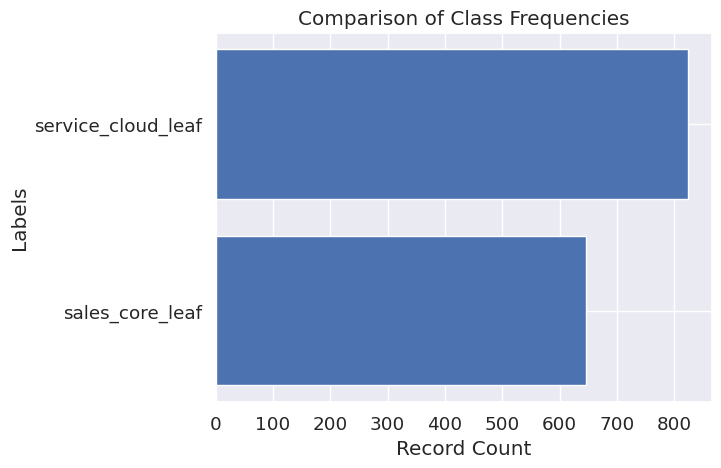

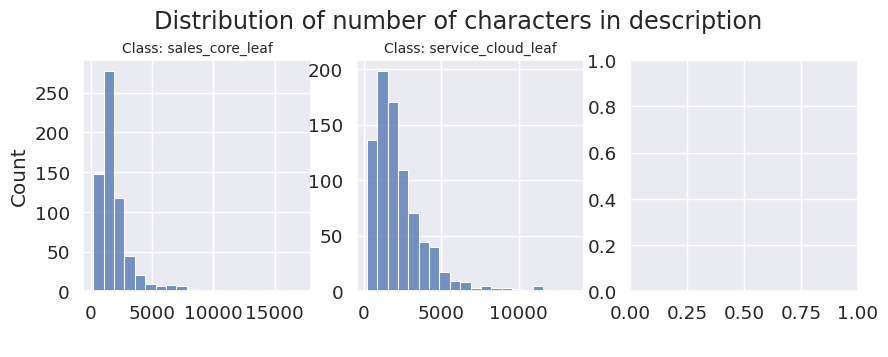

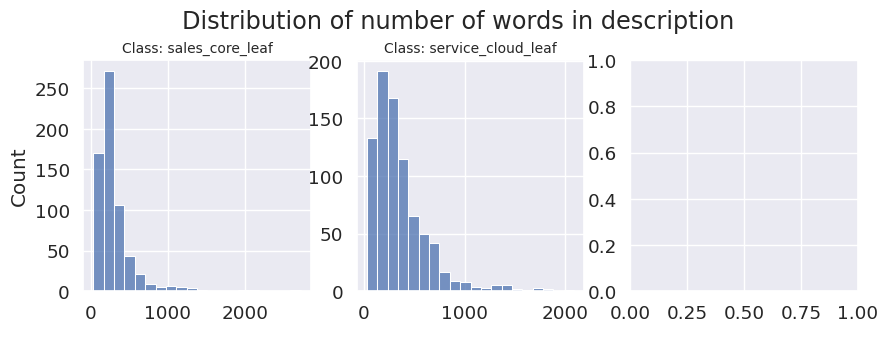

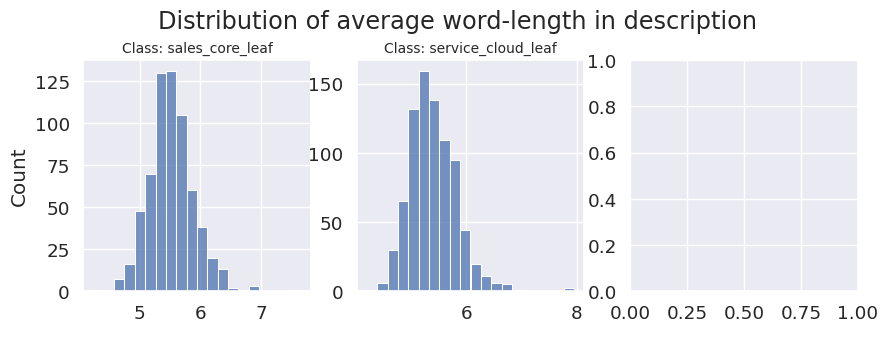

In [ ]:
# Distribution of number of characters in description
viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of characters in description
viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

## EDA Results

ADD HERE

# 4.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Test Split Functions

In [ ]:
# Feature-target split
def training_test_split(data, test_size = 0.2):

  # Feature-target split
  X, y = data.drop(['label'], axis = 1), data['label']

  # Train-test split (from complete data)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y, random_state = 55)
  data_train = pd.concat([X_train, y_train], axis = 1)

  # Validation-test split (from test data)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 55)
  data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

  print("Size of the training set:", len(data_train))
  print("Size of the validation set:", len(data_val))
  print("Size of the test set:", len(data_test))
  print()
  print("Labels in training set:", data_train['label'].nunique())
  print("Labels in validation set:", data_val['label'].nunique())
  print("Labels in test set:", data_test['label'].nunique())
  print()
  print("Columns in test set:", data_test.columns)
  print()


  # Create a histogram for the count of records in each label
  label_counts = data['label'].value_counts()
  plt.figure(figsize=(5, 3))
  plt.bar(label_counts.index.astype(str), label_counts.values)
  plt.xlabel('Label')
  plt.ylabel('Number of Records')
  plt.title('Distribution of Records Across Labels')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
  plt.tight_layout()
  plt.show()

  print()

  # Comparison of sizes of training set, validation set and test set
  values = np.array([len(data_train), len(data_val), len(data_test)])
  labels = ['Training Set', 'Validation Set', 'Test Set']

  # Create the pie chart with a hole for the donut effect
  plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), pctdistance=0.85)

  # Add a circle at the center to create the donut hole
  centre_circle = plt.Circle((0, 0), 0.70, fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  # Set the title
  plt.title("Comparison of sizes of training set, validation set and test set")

  # Ensure the circle's proportion is correct
  plt.axis('equal')

  # Display the chart
  plt.show()

  #Return Splot Data
  return data_train, data_val, data_test

## Test Split Analysis

No labels with 4 or fewer records found.
Size of the training set: 1176
Size of the validation set: 147
Size of the test set: 147

Labels in training set: 2
Labels in validation set: 2
Labels in test set: 2

Columns in test set: Index(['id', 'text', 'title', 'url', 'label'], dtype='object')



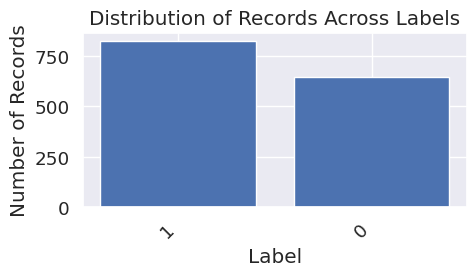

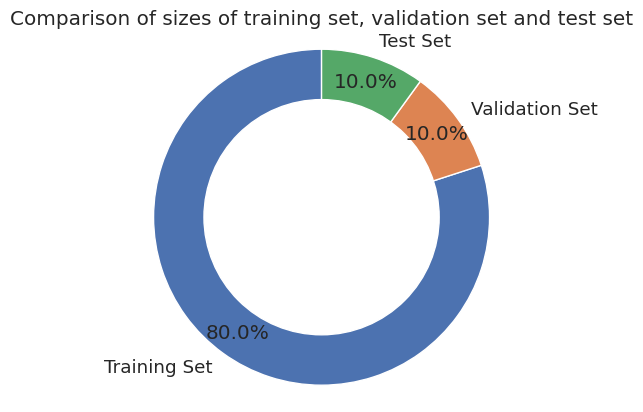

In [ ]:
# Feature-target split
data_train, data_val, data_test = training_test_split(data, test_size = 0.2)

# 5.&nbsp;Data Cleansing & Text Normalization

Address missing values and duplicates, followed by a series of text preprocessing steps. Text pre-processing includes converting text to lowercase, removing punctuation, handling HTML tags, and applying stemming/lemmatization. These cleaning functions ensure the data is standardized and ready for further analysis.

## Core Normalization Functions

In [ ]:
#Track a list of the descriptions and the function names
tn_funct = []; tn_desc = []

# RegexpTokenizer
regexp = RegexpTokenizer("[\w']+")

# Converting to lowercase
def convert_to_lowercase(text):
    return text.lower()

tn_funct.append('convert_to_lowercase(text)')
tn_desc.append('Converting to lowercase')
print('Testing', tn_funct[-1], "...")
text = "This is a FUNCTION that CoNvErTs a Text to lowercase"
print("Input: {}".format(text))
print("Output: {}".format(convert_to_lowercase(text)))
print()

# Removing whitespaces
def remove_whitespace(text):
    return text.strip()

tn_funct.append('remove_whitespace(text)')
tn_desc.append('Removing whitespaces')
print('Testing', tn_funct[-1], "...")
text = " \t This is a string \t "
print("Input: {}".format(text))
print("Output: {}".format(remove_whitespace(text)))
print()

# Removing punctuations
def remove_punctuation(text):
    punct_str = string.punctuation
    punct_str = punct_str.replace("'", "") # discarding apostrophe from the string to keep the contractions intact
    return text.translate(str.maketrans("", "", punct_str))

tn_funct.append('remove_punctuation(text)')
tn_desc.append('Removing punctuations')
print('Testing', tn_funct[-1], "...")
text = "Here's [an] example? {of} &a string. with.? punctuations!!!!"
print("Input: {}".format(text))
print("Output: {}".format(remove_punctuation(text)))
print()

# Removing HTML tags
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

tn_funct.append('remove_html(text)')
tn_desc.append('Removing HTML tags')
print('Testing', tn_funct[-1], "...")
text = '<a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>'
print("Input: {}".format(text))
print("Output: {}".format(remove_html(text)))
print()

# Removing emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags = re.UNICODE)
    return emoji_pattern.sub(r'', text)

tn_funct.append('remove_emoji(text)')
tn_desc.append('Removing emojis')
print('Testing', tn_funct[-1], "...")
text = "This innovative hd printing technique results in durable and spectacular looking prints 😊"
print("Input: {}".format(text))
print("Output: {}".format(remove_emoji(text)))
print()

# Removing other unicode characters
def remove_http(text):
    http = "https?://\S+|www\.\S+" # matching strings beginning with http (but not just "http")
    pattern = r"({})".format(http) # creating pattern
    return re.sub(pattern, "", text)

tn_funct.append('remove_http(text)')
tn_desc.append('Removing other unicode characters')
print('Testing', tn_funct[-1], "...")
text = "It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols"
print("Input: {}".format(text))
print("Output: {}".format(remove_http(text)))
print()

# Dictionary of acronyms
acronyms_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_acronyms.json'
acronyms_dict = pd.read_json(acronyms_url, typ = 'series')

print("Example: Original form of the acronym 'fyi' is '{}'".format(acronyms_dict['fyi']))
print()

# List of acronyms
acronyms_list = list(acronyms_dict.keys())

# Function to convert contractions in a text
def convert_acronyms(text):
    words = []
    for word in regexp.tokenize(text):
        if word in acronyms_list:
            words = words + acronyms_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

tn_funct.append('convert_acronyms(text)')
tn_desc.append('convert contractions in a text')
print('Testing', tn_funct[-1], "...")
text = "btw you've to fill in the details including dob"
print("Input: {}".format(text))
print("Output: {}".format(convert_acronyms(text)))
print()

# Dictionary of contractions
contractions_url = 'https://raw.githubusercontent.com/sugatagh/E-commerce-Text-Classification/main/JSON/english_contractions.json'
contractions_dict = pd.read_json(contractions_url, typ = 'series')

print("Example: Original form of the contraction 'aren't' is '{}'".format(contractions_dict["aren't"]))
print()

# List of contractions
contractions_list = list(contractions_dict.keys())

# Function to convert contractions in a text
def convert_contractions(text):
    words = []
    for word in regexp.tokenize(text):
        if word in contractions_list:
            words = words + contractions_dict[word].split()
        else:
            words = words + word.split()

    text_converted = " ".join(words)
    return text_converted

tn_funct.append('convert_contractions(text)')
tn_desc.append('convert contractions in a text')
print('Testing', tn_funct[-1], "...")
text = "he's doin' fine"
print("Input: {}".format(text))
print("Output: {}".format(convert_contractions(text)))
print()

# Stopwords
stops = stopwords.words("english") # stopwords
addstops = ["among", "onto", "shall", "thrice", "thus", "twice", "unto", "us", "would"] # additional stopwords
allstops = stops + addstops

# Function to remove stopwords from a list of texts
def remove_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in allstops])

tn_funct.append('remove_stopwords(text)')
tn_desc.append('remove stopwords from a list of texts')
print('Testing', tn_funct[-1], "...")
text = "This is a function that removes stopwords in a given text"
print("Input: {}".format(text))
print("Output: {}".format(remove_stopwords(text)))
print()

# pyspellchecker
spell = SpellChecker()

def pyspellchecker(text):
    word_list = regexp.tokenize(text)
    word_list_corrected = []
    for word in word_list:
        if word in spell.unknown(word_list):
            word_corrected = spell.correction(word)
            if word_corrected == None:
                word_list_corrected.append(word)
            else:
                word_list_corrected.append(word_corrected)
        else:
            word_list_corrected.append(word)
    text_corrected = " ".join(word_list_corrected)
    return text_corrected

tn_funct.append('pyspellchecker(text)')
tn_desc.append('remove to fix spelling errors in texts')
print('Testing', tn_funct[-1], "...")
text = "I'm goinng therre"
print("Input: {}".format(text))
print("Output: {}".format(pyspellchecker(text)))
print()

# Stemming
stemmer = PorterStemmer()
def text_stemmer(text):
    text_stem = " ".join([stemmer.stem(word) for word in regexp.tokenize(text)])
    return text_stem

tn_funct.append('text_stemmer(text)')
tn_desc.append('Stemming')
print('Testing', tn_funct[-1], "...")
text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_stemmer(text)))
print()

# Lemmatization
spacy_lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])
#lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):
    text_spacy = " ".join([token.lemma_ for token in spacy_lemmatizer(text)])
    #text_wordnet = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) # regexp.tokenize(text)
    return text_spacy
    #return text_wordnet

tn_funct.append('text_lemmatizer(text)')
tn_desc.append('Lemmatization')
print('Testing', tn_funct[-1], "...")
text = "Introducing lemmatization as an improvement over stemming"
print("Input: {}".format(text))
print("Output: {}".format(text_lemmatizer(text)))
print()

# Discardment of non-alphabetic words
def discard_non_alpha(text):
    word_list_non_alpha = [word for word in regexp.tokenize(text) if word.isalpha()]
    text_non_alpha = " ".join(word_list_non_alpha)
    return text_non_alpha

tn_funct.append('discard_non_alpha(text)')
tn_desc.append('Discardment of non-alphabetic words')
print('Testing', tn_funct[-1], "...")
text = "It is an ocean of thousands and 1000s of crowd"
print("Input: {}".format(text))
print("Output: {}".format(discard_non_alpha(text)))
print()

def keep_pos(text):
    tokens = regexp.tokenize(text)
    tokens_tagged = nltk.pos_tag(tokens)
    #keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW']
    keep_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'FW', 'PRP', 'PRPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WPS', 'WRB']
    keep_words = [x[0] for x in tokens_tagged if x[1] in keep_tags]
    return " ".join(keep_words)

tn_funct.append('keep_pos(text)')
tn_desc.append('Keep specific parts of speach')
print('Testing', tn_funct[-1], "...")
text = "He arrived at seven o'clock on Wednesday evening"
print("Input: {}".format(text))
tokens = regexp.tokenize(text)
print("Tokens: {}".format(tokens))
tokens_tagged = nltk.pos_tag(tokens)
print("Tagged Tokens: {}".format(tokens_tagged))
print("Output: {}".format(keep_pos(text)))
print()

# Additional stopwords
alphabets = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
prepositions = ["about", "above", "across", "after", "against", "among", "around", "at", "before", "behind", "below", "beside", "between", "by", "down", "during", "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out", "over", "through", "to", "toward", "under", "up", "with"]
prepositions_less_common = ["aboard", "along", "amid", "as", "beneath", "beyond", "but", "concerning", "considering", "despite", "except", "following", "like", "minus", "onto", "outside", "per", "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike", "until", "upon", "versus", "via", "within", "without"]
coordinating_conjunctions = ["and", "but", "for", "nor", "or", "so", "and", "yet"]
correlative_conjunctions = ["both", "and", "either", "or", "neither", "nor", "not", "only", "but", "whether", "or"]
subordinating_conjunctions = ["after", "although", "as", "as if", "as long as", "as much as", "as soon as", "as though", "because", "before", "by the time", "even if", "even though", "if", "in order that", "in case", "in the event that", "lest", "now that", "once", "only", "only if", "provided that", "since", "so", "supposing", "that", "than", "though", "till", "unless", "until", "when", "whenever", "where", "whereas", "wherever", "whether or not", "while"]
others = ["ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", "ûªs", "ûówe"]
additional_stops = alphabets + prepositions + prepositions_less_common + coordinating_conjunctions + correlative_conjunctions + subordinating_conjunctions + others

def remove_additional_stopwords(text):
    return " ".join([word for word in regexp.tokenize(text) if word not in additional_stops])

tn_funct.append('remove_additional_stopwords')
tn_desc.append('Custom list of stop words to remove')
print('Testing', tn_funct[-1], "...")
print('no test defined.')

Testing convert_to_lowercase(text) ...
Input: This is a FUNCTION that CoNvErTs a Text to lowercase
Output: this is a function that converts a text to lowercase

Testing remove_whitespace(text) ...
Input:  	 This is a string 	 
Output: This is a string

Testing remove_punctuation(text) ...
Input: Here's [an] example? {of} &a string. with.? punctuations!!!!
Output: Here's an example of a string with punctuations

Testing remove_html(text) ...
Input: <a href = "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification"> Ecommerce Text Classification </a>
Output:  Ecommerce Text Classification 

Testing remove_emoji(text) ...
Input: This innovative hd printing technique results in durable and spectacular looking prints 😊
Output: This innovative hd printing technique results in durable and spectacular looking prints 

Testing remove_http(text) ...
Input: It's a function that removes links starting with http: or https such as https://en.wikipedia.org/wiki/Unicode_symbols
O

In [ ]:
# Execute the set of desired text normalization functions
def text_normalizer(text):
    text = convert_to_lowercase(text)
    text = remove_whitespace(text)
    text = re.sub('\n' , '', text) # converting text to one line
    text = re.sub('\[.*?\]', '', text) # removing square brackets
    text = remove_http(text)
    text = remove_punctuation(text)
    text = remove_html(text)
    text = remove_emoji(text)
    text = convert_acronyms(text)
    text = convert_contractions(text)
    text = remove_stopwords(text)
    # text = pyspellchecker(text)
    text = text_lemmatizer(text)
    # text = text_stemmer(text)
    text = discard_non_alpha(text)
    text = keep_pos(text)
    text = remove_additional_stopwords(text)
    return text

text = "We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization"
print("Input: {}".format(text))
print("Output: {}".format(text_normalizer(text)))
print()

Input: We'll combine all functions into 1 SINGLE FUNCTION 🙂 & apply on @product #descriptions https://en.wikipedia.org/wiki/Text_normalization
Output: combine function function apply product description



In [ ]:
# Apply the text normalization to the data sets and summerize the application
def apply_text_normalizer(data_train, data_val, data_test):
  # Implementing text normalization
  data_train_norm, data_val_norm, data_test_norm = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

  data_train_norm['normalized text'] = data_train['text'].apply(text_normalizer)
  data_val_norm['normalized text'] = data_val['text'].apply(text_normalizer)
  data_test_norm['normalized text'] = data_test['text'].apply(text_normalizer)

  data_train_norm['label'] = data_train['label']
  data_val_norm['label'] = data_val['label']
  data_test_norm['label'] = data_test['label']

  data_train['normalized text'] = data_train_norm['normalized text']
  data_val['normalized text'] = data_val_norm['normalized text']
  data_test['normalized text'] = data_test_norm['normalized text']

  print("Size of the training set:", len(data_train_norm))
  print("Size of the validation set:", len(data_val_norm))
  print("Size of the test set:", len(data_test_norm))
  print()
  print("Labels in training set:", data_train_norm['label'].nunique())
  print("Labels in validation set:", data_val_norm['label'].nunique())
  print("Labels in test set:", data_test_norm['label'].nunique())
  print()
  # Display normalized training data
  print("Sample of test set [normalized]:\n")
  print("Columns in test set [normalized]:", data_test_norm.columns, "\n")
  display(data_train_norm.head(3))
  print()
  # Display normalized training data
  print("Sample of test set [data]:\n")
  print("Columns in test set [data]:", data_test.columns, "\n")
  display(data_train.head(3))
  print()

  return data_train_norm, data_val_norm, data_test_norm, data_train, data_val, data_test

## Apply Text Normalization

In [ ]:
%%time
# Apply text normalization
data_train_norm, data_val_norm, data_test_norm, data_train, data_val, data_test = apply_text_normalizer(data_train, data_val, data_test)

Size of the training set: 1176
Size of the validation set: 147
Size of the test set: 147

Labels in training set: 2
Labels in validation set: 2
Labels in test set: 2

Columns in test set [normalized]: Index(['normalized text', 'label'], dtype='object')
Columns in test set [data]: Index(['id', 'text', 'title', 'url', 'label', 'normalized text'], dtype='object')

Sample of test set [normalized]:



,normalized text,label
1414,employee service setup integrate employee serv...,1
486,turn account plan help sale team nurture grow ...,0
1005,create work plan identify incident problem cre...,1



Sample of test set [data]:



,id,text,title,url,label,normalized text
1414,es_employee_service_setup_leaf,Employee Service Setup Integrate Employee Serv...,Employee Service Setup,https://help.salesforce.com/s/articleView?id=s...,1,employee service setup integrate employee serv...
486,account_plans_setup_leaf,Turn on Account Plans To help your sales team ...,Turn on Account Plans,https://help.salesforce.com/s/articleView?id=s...,0,turn account plan help sale team nurture grow ...
1005,incident_mgmt_create_work_plan_leaf,Create a Work Plan After you identify an incid...,Create a Work Plan,https://help.salesforce.com/s/articleView?id=s...,1,create work plan identify incident problem cre...



CPU times: user 1min 4s, sys: 224 ms, total: 1min 4s
Wall time: 1min 14s


In [ ]:
# Preview the changes for the before and after text
print(textwrap.fill(data_train['text'][0], width=100))
print('\n## change to ##\n')
print(textwrap.fill(data_train['normalized text'][0], width=100))

# 6.&nbsp;Feature Engineering with TF-IDF

The TfidfVectorizer from scikit-learn is used to convert the text documents into numerical features. The vectorizer transforms the collection of documents into a matrix of token counts, which is then normalized using the Term Frequency-Inverse Document Frequency (TF-IDF) transformation. This matrix representation of the text data serves as input to the machine learning models.

## TF_IDF Functions

In [ ]:
def tfid_vectorizer(data_train_norm, data_val_norm, data_test_norm):
  # Features and labels
  X_train_norm, y_train = data_train_norm['normalized text'].tolist(), data_train_norm['label'].tolist()
  X_val_norm, y_val = data_val_norm['normalized text'].tolist(), data_val_norm['label'].tolist()
  X_test_norm, y_test = data_test_norm['normalized text'].tolist(), data_test_norm['label'].tolist()

  # TF-IDF vectorization
  TfidfVec = TfidfVectorizer(ngram_range = (1, 1))
  X_train_tfidf = TfidfVec.fit_transform(X_train_norm)
  X_val_tfidf = TfidfVec.transform(X_val_norm)
  X_test_tfidf = TfidfVec.transform(X_test_norm)

  #Print The Size of the lists
  print()
  print("Shape of the training set:", X_train_tfidf.shape)
  print("Shape of the validation set:", X_val_tfidf.shape)
  print("Shape of the test set:", X_test_tfidf.shape)
  print()
  print("Size of the training labels:", len(y_train))
  print("Size of the validation labels:", len(y_val))
  print("Size of the test labels:", len(y_test))
  print()

  return X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test

## Vectorization

In [ ]:
# Vectorize
X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test = tfid_vectorizer(data_train_norm, data_val_norm, data_test_norm)

print("Shape of the training set:", X_train_tfidf.shape)
print("Shape of the validation set:", X_val_tfidf.shape)
print("Shape of the test set:", X_test_tfidf.shape)

print("Size of the training labels:", len(y_train))
print("Size of the validation labels:", len(y_val))
print("Size of the test labels:", len(y_test))

# 7.&nbsp; Baseline Models: Supervised

## Model Functions

In [ ]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val, names, models):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    x = time.time()
    for model in models:
        model.fit(X_train, y_train)
        y_train_pred, y_val_pred = model.predict(X_train), model.predict(X_val)
        score_train.append(accuracy_score(y_train, y_train_pred))
        score_val.append(accuracy_score(y_val, y_val_pred))

    score_df["Classifier"], score_df["Training accuracy"], score_df["Validation accuracy"] = names, score_train, score_val
    score_df.sort_values(by = 'Validation accuracy', ascending = False, inplace = True)
    return score_df

In [ ]:
# Function to Execute a batch of baseline models
def tfid_baseline(X_train_tfidf, y_train, X_val_tfidf, y_val):

  # Classifiers
  names = [
      "Logistic Regression",
      "KNN Classifier",
      "Decision Tree",
      "Linear SVM",
      "Random Forest",
      "SGD Classifier",
      "Ridge Classifier",
      "XGBoost",
      "AdaBoost",
  ]

  models = [
      LogisticRegression(max_iter = 1000),
      KNeighborsClassifier(n_neighbors = 149, n_jobs = -1),
      DecisionTreeClassifier(),
      svm.SVC(kernel = 'linear', probability=True),
      RandomForestClassifier(n_estimators = 100),
      SGDClassifier(loss = 'hinge'),
      RidgeClassifier(),
      XGBClassifier(),
      AdaBoostClassifier()
  ]

  # Summary of baseline models
  score_results = score(X_train_tfidf, y_train, X_val_tfidf, y_val, names = names, models = models)
  display(score_results)

## Build, Train, and Evaluate the Model

In [ ]:
# Baseline
tfid_baseline(X_train_tfidf, y_train, X_val_tfidf, y_val)


Shape of the training set: (1176, 3807)
Shape of the validation set: (147, 3807)
Shape of the test set: (147, 3807)

Size of the training labels: 1176
Size of the validation labels: 147
Size of the test labels: 147



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



,Classifier,Training accuracy,Validation accuracy
0,Logistic Regression,0.998299,0.993197
3,Linear SVM,0.999150,0.993197
4,Random Forest,1.000000,0.993197
5,SGD Classifier,0.999150,0.993197
6,Ridge Classifier,0.999150,0.993197
7,XGBoost,1.000000,0.979592
8,AdaBoost,1.000000,0.972789
2,Decision Tree,1.000000,0.959184
1,KNN Classifier,0.955782,0.945578


# 8.&nbsp; Hyperparameter Tuning

## Tuning Functions

In [ ]:
# Hyperparameter tuning for linear SVM
def tfid_svm_hyper_param_tune(X_train_tfidf, y_train, X_val_tfidf, y_val):
  svm_classifier = svm.SVC()
  params_svm = {
      'kernel': ['linear'],
      'C': [0.1, 1, 10, 100],
      'probability' : [True]
  }

  best_model_svm, best_params_svm, best_score_svm, count = svm_classifier, ParameterGrid(params_svm)[0], 0, 0
  for g in ParameterGrid(params_svm):
      time_start = time.time()
      count += 1
      print(f"Gridpoint #{count}: {g}")
      svm_classifier.set_params(**g)
      svm_classifier.fit(X_train_tfidf, y_train)
      y_train_pred, y_val_pred = svm_classifier.predict(X_train_tfidf), svm_classifier.predict(X_val_tfidf)
      score_train, score_val = accuracy_score(y_train, y_train_pred), accuracy_score(y_val, y_val_pred)
      time_stop = time.time()
      m, s = int(time_stop - time_start) // 60, int(time_stop - time_start) % 60
      print(f"Training accuracy: {score_train}, Validation accuracy: {score_val}, Runtime: {m}m{s}s")
      print(" ")
      if score_val > best_score_svm:
          best_params_svm, best_score_svm = g, score_val

  best_model_tfidf, best_params_tfidf, best_score_tfidf = svm.SVC(), best_params_svm, best_score_svm
  best_model_tfidf.set_params(**best_params_tfidf)
  print(f"Best model: {best_model_tfidf}")
  print(" ")
  print(f"Best parameters: {best_params_tfidf}")
  print(f"Best validation accuracy: {best_score_tfidf}")

  return best_model_tfidf, best_params_tfidf, best_score_tfidf

## Execute Hyperparameter Tuning

In [ ]:
# Best model
best_model_tfidf, best_params_tfidf, best_score_tfidf = tfid_svm_hyper_param_tune(X_train_tfidf, y_train, X_val_tfidf, y_val)

Gridpoint #1: {'C': 0.1, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9948979591836735, Validation accuracy: 0.9931972789115646, Runtime: 0m3s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9991496598639455, Validation accuracy: 0.9931972789115646, Runtime: 0m1s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9991496598639455, Validation accuracy: 0.9931972789115646, Runtime: 0m1s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear', 'probability': True}
Training accuracy: 1.0, Validation accuracy: 0.9931972789115646, Runtime: 0m1s
 
Best model: SVC(C=0.1, kernel='linear', probability=True)
 
Best parameters: {'C': 0.1, 'kernel': 'linear', 'probability': True}
Best validation accuracy: 0.9931972789115646


# 9.&nbsp;Final Prediction and Evaluation

## Evaluation Functions

In [ ]:
# Generate score analysis report
def generate_score_analysis(best_model, X_test_vec, y_test, y_test_pred):
  # Print the model accuracy
  score_test = accuracy_score(y_test, y_test_pred)
  print(pd.Series({"Test accuracy": score_test}).to_string())
  print(" ")
  # Print the Test Score Summary
  print(metrics.classification_report(y_test, y_test_pred))
  print(" ")

  """
  Plots ROC curves for multiple classes in a grid layout.

  Args:
    X_test_vec: Test data vector.
    y_test: True labels for test data.
    y_test_pred_proba: Predicted probabilities for test data.
    num_classes: Number of classes.
    ncols: Number of columns in the grid.
  """

  # Get Test Probabilities
  # Assuming 'best_model' has 'predict_proba'
  y_test_pred_proba = best_model.predict_proba(X_test_vec)

   # Get the number of classes
  num_classes = y_test_pred_proba.shape[1]
  print("Number of Classes:", num_classes, "\n")

  ncols = 3
  nrows = int(np.ceil(num_classes / ncols))
  fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows))
  axes = axes.flatten()  # Flatten the axes array for easier iteration

  # Handle multiclass by iterating through classes:
  for i in range(num_classes):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_proba[:, i], pos_label=i)
    roc_auc = metrics.auc(fpr, tpr)

    axes[i].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_xlim([-0.05, 1.0])
    axes[i].set_ylim([-0.05, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC for Class {i}')
    axes[i].legend(loc="lower right")

  # Remove any unused subplots
  for i in range(num_classes, len(axes)):
    fig.delaxes(axes[i])

  plt.tight_layout()
  plt.show()
  print()

In [ ]:
def conf_mat(y_test, y_test_pred, figsize=(10, 8), font_scale=1.2, annot_kws_size=16):
    """
    Generates and displays a confusion matrix.

    Args:
    y_test: The true labels.
    y_test_pred: The predicted labels.
    figsize: The size of the figure.
    font_scale: The font scale for the labels.
    annot_kws_size: The font size for the annotations.
    """
    # Get unique class names from the true labels (y_test)
    class_names = list(np.unique(np.concatenate((y_test, y_test_pred))))

    tick_marks_x = [0.5, 1.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    sns.set(font_scale=font_scale)
    sns.heatmap(
        confusion_matrix_df,
        annot=True,
        fmt="d",
        cmap="YlGnBu",
        cbar=False,
        annot_kws={"size": annot_kws_size},
    )  # font size
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    print()

In [ ]:
list(np.unique(np.concatenate((y_test, y_test_pred))))

[0, 1]

In [ ]:
# Run Best Model Predictions
def run_best_model(best_model, data_test, label_dict, X_train_vec, X_test_vec, y_train, y_test):
  print()
  print("Shape of the training set:", X_train_vec.shape)
  print("Shape of the test set:", X_test_vec.shape)
  print()
  print("Size of the training labels:", len(y_train))
  print("Size of the test labels:", len(y_test))
  print()

  print("Label Dict:", label_dict)
  print()

  # Prediction and evaluation on test set
  best_model.fit(X_train_vec, y_train)
  y_test_pred = best_model.predict(X_test_vec)

  # Get Test Probabilities
  # Assuming 'best_model' has 'predict_proba'
  y_test_pred_proba = best_model.predict_proba(X_test_vec)

  # Define a Probability Threshold
  other_threshold = 0.6

  # Apply the Custom Decision Rule
  pred_assigned = np.argmax(y_test_pred_proba, axis = 1)
  pred_assigned_proba = np.max(y_test_pred_proba, axis = 1)
  y_test_pred_custom = np.where(pred_assigned_proba < other_threshold, -1, y_test_pred)
  basic_error = np.where(y_test != y_test_pred, 1, 0)
  custom_error = np.where(np.logical_and((y_test != y_test_pred_custom), (basic_error != 1)), 1, 0)

  # Build a dataframe of predictions, probabilities, actual label
  df_pred_results = data_test
  df_pred_results['label text'] = df_pred_results['label']
  # Replace the labels with the encoded values
  df_pred_results.replace({'label text': label_dict}, inplace = True)
  # Add new columns
  df_pred_results['actual label'] = y_test
  df_pred_results['predicted label'] = y_test_pred
  df_pred_results['predicted probability'] = pred_assigned_proba
  df_pred_results['predicted probability label'] = pred_assigned
  df_pred_results['custom predicted label'] = y_test_pred_custom
  df_pred_results['basic error'] = basic_error
  df_pred_results['custom error'] = custom_error

  return y_test_pred, y_test_pred_proba, df_pred_results

## Train the Final Model

In [ ]:
# Prediction and evaluation on test set
best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
y_test_pred, y_test_pred_proba, df_pred_results = run_best_model(best_model, data_test, inverted_label_dict, X_train_vec, X_test_vec, y_train, y_test)

display(df_pred_results.head(3))


Shape of the training set: (1176, 3807)
Shape of the test set: (147, 3807)

Size of the training labels: 1176
Size of the test labels: 147

Label Dict: {0: 'sales_core_leaf', 1: 'service_cloud_leaf'}



,id,text,title,url,label,normalized text,Actual Label,Predicted Label,Predicted Probability,Predicted Probability Label,...,label text,actual label,predicted label,predicted probability,predicted probability label,custom predicted label,basic accuracy,custom accuracy,basic error,custom error
1275,omnichannel_supervisor_monitor_agents_leaf,Enable Omni Supervisor Train and monitor agent...,Enable Omni Supervisor,https://help.salesforce.com/s/articleView?id=s...,1,omni supervisor train monitor agent supervisor...,1,1,1.0,1,...,service_cloud_leaf,1,1,1.0,1,1,1,1,0,0
1462,es_interact_with_employees_leaf,Interact with Employees In HR Service Workspac...,Interact with Employees,https://help.salesforce.com/s/articleView?id=s...,1,employee hr service workspace chat employee an...,1,1,1.0,1,...,service_cloud_leaf,1,1,1.0,1,1,1,1,0,0
1040,knowledge_customizing_leaf,Plan Your Knowledge Base in Salesforce Classic...,Plan Your Knowledge Base in Salesforce Classic,https://help.salesforce.com/s/articleView?id=s...,1,plan knowledge salesforce consider company nee...,1,1,1.0,1,...,service_cloud_leaf,1,1,1.0,1,1,1,1,0,0


## Evaluate the Model

Test accuracy    0.986395
 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        66
           1       0.98      1.00      0.99        81

    accuracy                           0.99       147
   macro avg       0.99      0.98      0.99       147
weighted avg       0.99      0.99      0.99       147

 
Number of Classes: 2 



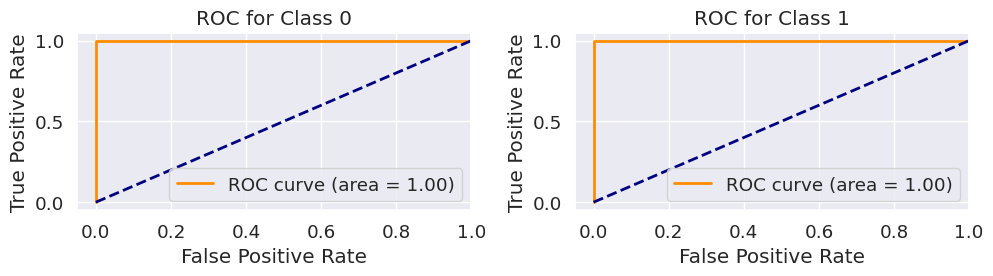

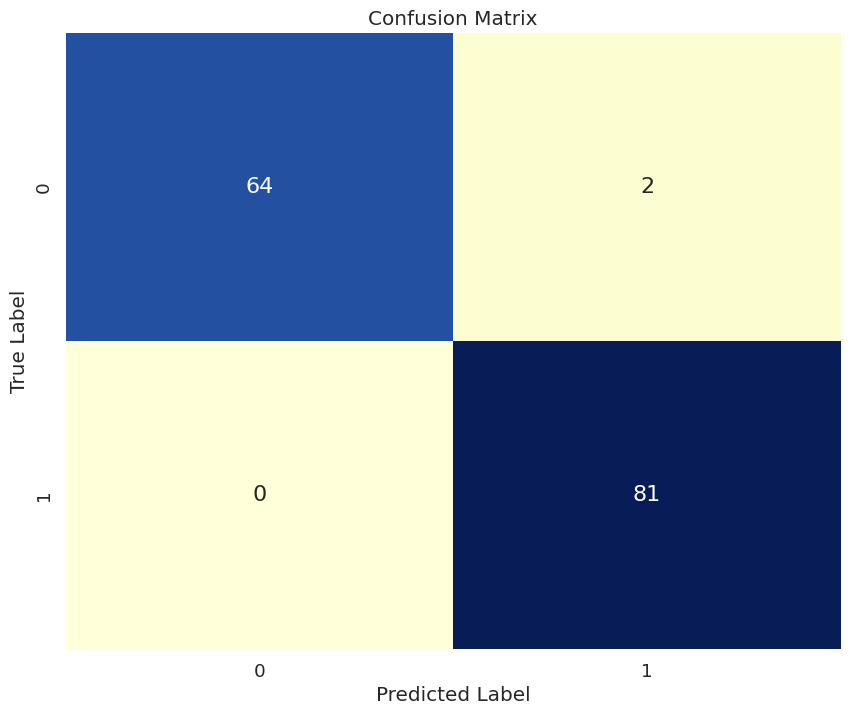

In [ ]:
# Generate score analysis report
generate_score_analysis(best_model, X_test_vec, y_test, y_test_pred)

#Display Confusion Matrix
conf_mat(y_test, y_test_pred, figsize=(10, 8), font_scale=1.2, annot_kws_size=16)

## Explore Errors

In [ ]:
def error_analysis(df_pred_results):
  #Overall Errors Detected
  basic_error_count = df_pred_results['basic error'].sum()
  custom_error_count = df_pred_results['custom error'].sum()
  total_samples = len(df_pred_results)

  basic_error_rate = (basic_error_count / total_samples) * 100
  custom_error_rate = (custom_error_count / total_samples) * 100
  total_errors_rate = (basic_error_count + custom_error_count) / total_samples * 100

  print(f"Basic Error Rate: {basic_error_rate:.2f}%")
  print(f"Custom Error Rate: {custom_error_rate:.2f}%")
  print(f"Total Error Rate: {total_errors_rate:.2f}%")

  # Display rows where basic_error or custom_error = 0
  df_pred_errors = df_pred_results[(df_pred_results['basic error'] == 1) | (df_pred_results['custom error'] == 1)]
  # Group by the actual and predicted labels to count errors
  error_summary = df_pred_errors.groupby(['label text', 'actual label', 'predicted label'])['text'].count().reset_index(name='error count')
  total_errors = len(df_pred_errors)
  error_summary['error percentage'] = (error_summary['error count'] / total_errors) * 100
  # Display the summary
  print("\nError Summary with Percentage:")
  display(error_summary)
  print()
  # Display the error records
  display(df_pred_errors.head(5))

error_analysis(df_pred_results)

Basic Error Rate: 1.36%
Custom Error Rate: 0.00%
Total Error Rate: 1.36%

Error Summary with Percentage:


,label text,actual label,predicted label,error count,error percentage
0,sales_core_leaf,0,1,2,100.0


,id,text,title,url,label,normalized text,Actual Label,Predicted Label,Predicted Probability,Predicted Probability Label,...,label text,actual label,predicted label,predicted probability,predicted probability label,custom predicted label,basic accuracy,custom accuracy,basic error,custom error
318,contacts_selfservice_leaf,Enable Self-Service for Contacts and Person Ac...,Enable Self-Service for Contacts and Person Ac...,https://help.salesforce.com/s/articleView?id=s...,0,selfservice contact person account provide acc...,0,1,0.752961,0,...,sales_core_leaf,0,1,0.770175,0,1,0,0,1,0
461,forecasts3_forecasts3_charts_intro_leaf,Salesforce Help Article Loading × Sorry to int...,Salesforce Forecasting Charts,https://help.salesforce.com/s/articleView?id=s...,0,salesforce help article load sorry page error ...,0,1,0.743996,1,...,sales_core_leaf,0,1,0.741203,1,1,0,0,1,0


In [ ]:
# Example of the text from the article that failed mapping
example_text = data_merged['text'].iloc[461]
# Print to Screen
print("Length of Text:", len(example_text), "\n")
print(textwrap.fill(example_text, width=100))

Length of Text: 2518 

Salesforce Help Article Loading × Sorry to interrupt This page has an error. You might just need to
refresh it. [PromiseRejection: [object Object]] Refresh Action Button In Salesforce Flow Winter ‘25
Release Read More Close Chat & Live Agent Retirement Read More Close We looked high and low but
couldn't find that page. Go Home 1-800-667-6389 SALESFORCE Privacy Statement Security Statement
Terms of Use Participation Guidelines Cookie Preference Center Your Privacy Choices COMMUNITY
AppExchange Salesforce Admins Salesforce Developers Trailhead Training Trust SUPPORT & SERVICES Need
help? Find more resources or connect with an expert. Get Support Powered by Experience Cloud ©
Copyright 2024 Salesforce.com, inc. All rights reserved. Various trademarks held by their respective
owners. Salesforce, Inc. Salesforce Tower, 415 Mission Street, 3rd Floor, San Francisco, CA 94105,
United States English Select Org Select Org English Français Deutsch Italiano 日本語 Español (Méxi

In [ ]:
# All records where the scrape script failed with the code "Salesforce Help Article Loading ×"
df_scrape_errors = data_merged[data_merged['text'].str.contains("Salesforce Help Article Loading ×")]
print(f"Number of sraping errors in dataset: {len(df_scrape_errors)}")
display(df_scrape_errors)

Number of sraping errors in dataset: 3


,aria-level,title,id,l0_id,l1_id,l2_id,l0_title,l1_title,l2_title,url,text
142,5,Set and Edit Product Prices in Salesforce Classic,products_prices_aloha_leaf,sales_core_leaf,sales_core_turn_opptys_into_deals_leaf,products_pricebooks_leaf,Sales Cloud Basics,Turn Opportunities into Deals,Products and Price Books,https://help.salesforce.com/s/articleView?id=s...,Salesforce Help Article Loading × Sorry to int...
461,5,Salesforce Forecasting Charts,forecasts3_forecasts3_charts_intro_leaf,sales_core_leaf,sales_core_manage_sales_team_leaf,forecasts3_intro_leaf,Sales Cloud Basics,Manage a Sales Team,Salesforce Forecasting,https://help.salesforce.com/s/articleView?id=s...,Salesforce Help Article Loading × Sorry to int...
717,5,Case Comments,case_comments_leaf,service_cloud_leaf,support_admins_intro_leaf,cases_intro_leaf,Service Cloud,Set Up Service Cloud Basics,Cases,https://help.salesforce.com/s/articleView?id=s...,Salesforce Help Article Loading × Sorry to int...


# 10.&nbsp;Scale the Auto-Classifier

## Auto-Classifier Functions

In [ ]:
def print_header_break(header_text= ''):
  f_text = ' --  ' + header_text.upper() + '  --'
  f_len = len(f_text)
  print('\n', '-' * f_len)
  print(f_text)
  print('', '-' * f_len, '\n')

print_header_break('Rerun Process L2')

In [ ]:
def run_full_proj(data, scope = 'l0_id'):
  '''
  Variable List
  -- data, label_dict, inverted_label_dict
  -- data_by_label
  -- summary_table
  -- data_train, data_val, data_test
  -- data_train_norm, data_val_norm, data_test_norm
  -- X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test
  -- best_model_tfidf, best_params_tfidf, best_score_tfidf
  -- best_model, X_train_vec, X_test_vec
  -- y_test_pred
  '''

  print_header_break('Scope Data')
  # Select the scope of data and label to target
  data, label_dict, inverted_label_dict = scope_data(data_merged, label_col = scope)
  print("label_dictionary:", label_dict, "\n")
  # Create the data by label structure
  data_by_label = create_data_by_label(data, 'label')
  # Display the scoped dataframe
  print("\nSample of source data:\n")
  display(data.head(5))
  # Group by l0_id and l1_id and count the number of records in each group
  summary_table = data.groupby(['label']).size().reset_index(name='record_count')
  # Display the Summary Table
  print("\nSummary of data by labels:\n")
  display(summary_table)

  # Exploritory Data Analysis
  #print_header_break('Exploritory Data Analysis')
  # Distribution of number of characters in description
  #viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
  # Distribution of number of characters in description
  #viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
  # Distribution of number of words in description
  #viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
  # Distribution of number of words in description
  #viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

  # Feature-target split
  print_header_break('Training-Validation-Test-Split')
  data_train, data_val, data_test = training_test_split(data, test_size = 0.2)

  # Apply text normalization
  print_header_break('Text Normalization')
  data_train_norm, data_val_norm, data_test_norm, data_train, data_val, data_test = apply_text_normalizer(data_train, data_val, data_test)
  # Display normalized training data
  print("\nSample of normalized training data:\n")
  display(data_train_norm.head(5))

  # Vectorize
  print_header_break('TF-IDF Baseline')
  X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test = tfid_vectorizer(data_train_norm, data_val_norm, data_test_norm)
  # Baseline
  tfid_baseline(X_train_tfidf, y_train, X_val_tfidf, y_val)

  # Hyperparameter tuning for linear SVM
  print_header_break('TF-IDF Hyperparameter Tuning')
  best_model_tfidf, best_params_tfidf, best_score_tfidf = tfid_svm_hyper_param_tune(X_train_tfidf, y_train, X_val_tfidf, y_val)

  # Prediction and evaluation on test set
  print_header_break('Final Prediction and Evaluation')
  best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
  y_test_pred, y_test_pred_proba, df_pred_results = run_best_model(best_model, data_test, inverted_label_dict, X_train_vec, X_test_vec, y_train, y_test)
  display(df_pred_results.head(3))
  #Generate score analysis report
  generate_score_analysis(best_model, X_test_vec, y_test, y_test_pred)
  #Display Confusion Matrix
  conf_mat(y_test, y_test_pred, figsize=(10, 8), font_scale=1.2, annot_kws_size=16)
  # Summerize Errors
  error_analysis(df_pred_results)

## Rerun Process for L1

In [ ]:
# Select the scope of data and label to target
scope = 'l1_id'
data, label_dict, inverted_label_dict = scope_data(data_merged, label_col = scope)
print("label_dictionary:", label_dict, "\n")

# Create the data by label structure
data_by_label = create_data_by_label(data, 'label')

# Display the scoped dataframe
data

Memory usage       0.03 MB
Dataset shape    (1470, 3)
Columns in table: ['id', 'label', 'text']
label_dictionary: {'sales_core_bring_in_leads_leaf': 0, 'sales_core_turn_opptys_into_deals_leaf': 1, 'sales_core_manage_accounts_contacts_leaf': 2, 'sales_core_salesforce_maps_lite_leaf': 3, 'sales_core_manage_sales_team_leaf': 4, 'sales_core_artificial_intelligence_parent_leaf': 5, 'sales_core_legacy_features_leaf': 6, 'support_admins_intro_leaf': 7, 'support_productivity_leaf': 8, 'support_deflection_leaf': 9, 'support_routing_automation_leaf': 10, 'support_metrics_leaf': 11} 

Size of the data by label dictionary: 12 



,id,label,text
0,campaigns_def_leaf,0,Get to Know Salesforce Campaigns Many cross-fu...
1,campaigns_tour_leaf,0,Tour the Campaigns Object To get familiar with...
2,campaigns_use_cases_leaf,0,How Campaigns Can Help You can use Salesforce ...
3,campaigns_use_cases_other_clouds_leaf,0,Use Campaigns with Other Clouds For a more com...
4,campaigns_hierarchy_leaf,0,Understand Campaign Hierarchy To organize and ...
...,...,...,...
1465,rules_viewing_escrules_queue_leaf,11,Monitor the Case Escalation Rule Queue When Sa...
1466,entitlement_process_queue_leaf,11,Monitor the Entitlement Process Queue When Sal...
1467,monitor_article_automated_actions_leaf,11,Monitor Automated Article Process Actions Sale...
1468,reports_support_crts_leaf,11,Use Custom Report Types to Report on Support A...


In [ ]:
# Group by l0_id and l1_id and count the number of records in each group
summary_table = data.groupby(['label']).size().reset_index(name='record_count')

# Display the Summary Table
summary_table

,label,record_count
0,0,133
1,1,120
2,2,99
3,3,3
4,4,275
5,5,5
6,6,11
7,7,187
8,8,174
9,9,192


[133, 120, 99, 3, 275, 5, 11, 187, 174, 192, 147, 124]
['sales_core_bring_in_leads_leaf', 'sales_core_turn_opptys_into_deals_leaf', 'sales_core_manage_accounts_contacts_leaf', 'sales_core_salesforce_maps_lite_leaf', 'sales_core_manage_sales_team_leaf', 'sales_core_artificial_intelligence_parent_leaf', 'sales_core_legacy_features_leaf', 'support_admins_intro_leaf', 'support_productivity_leaf', 'support_deflection_leaf', 'support_routing_automation_leaf', 'support_metrics_leaf']


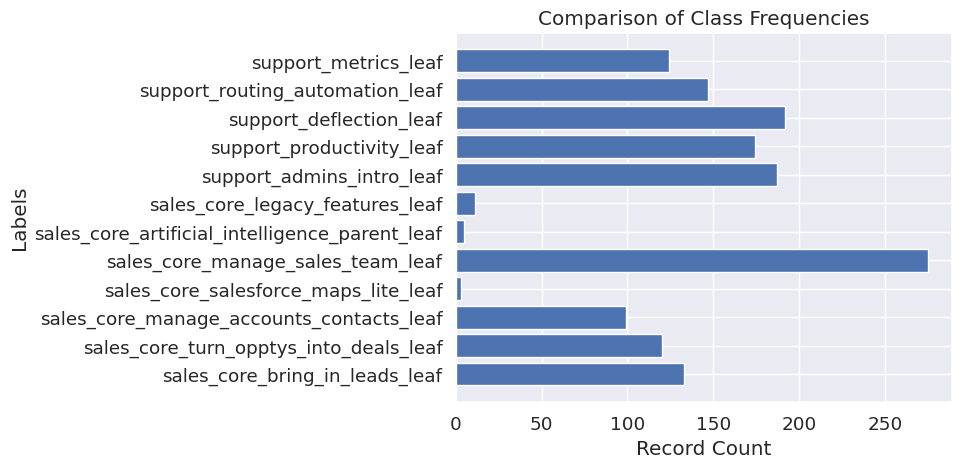

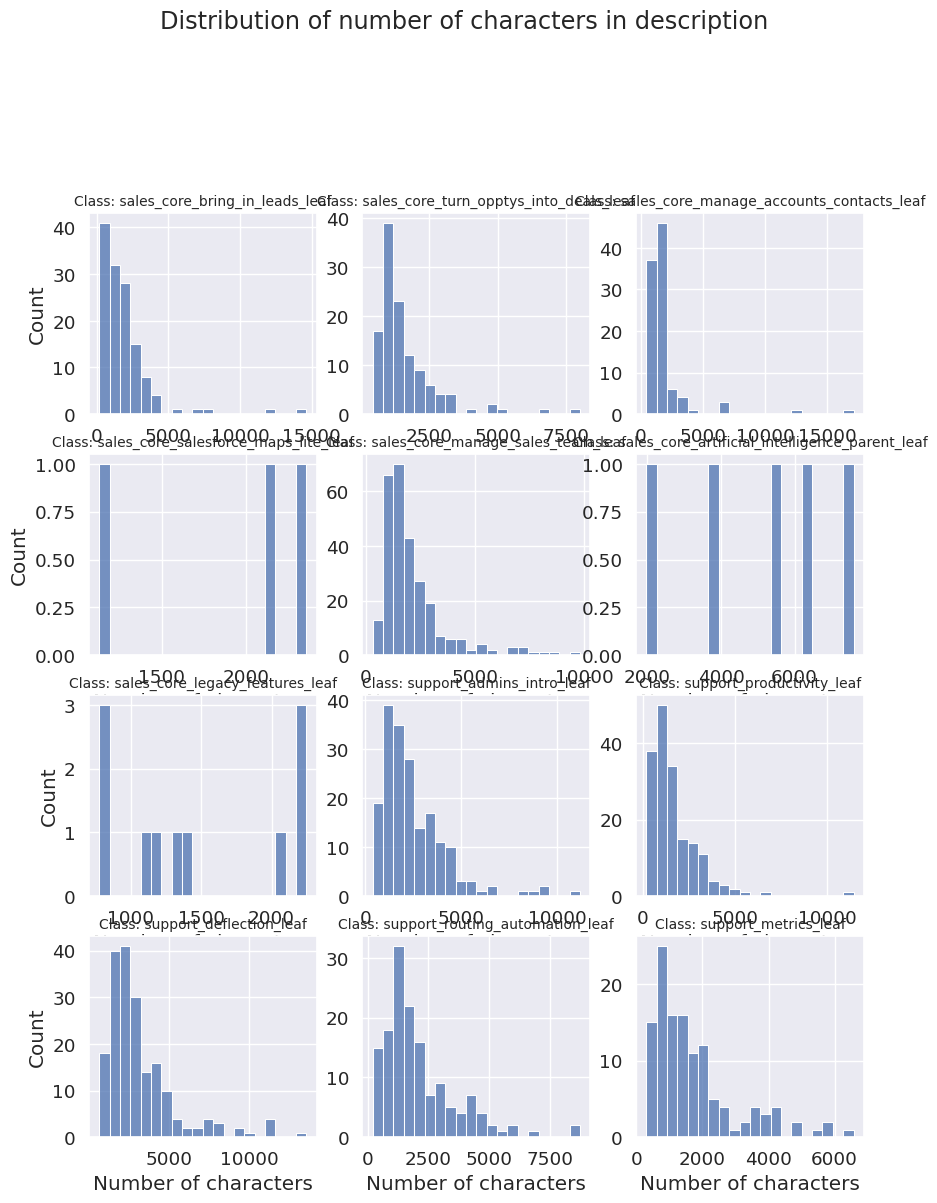

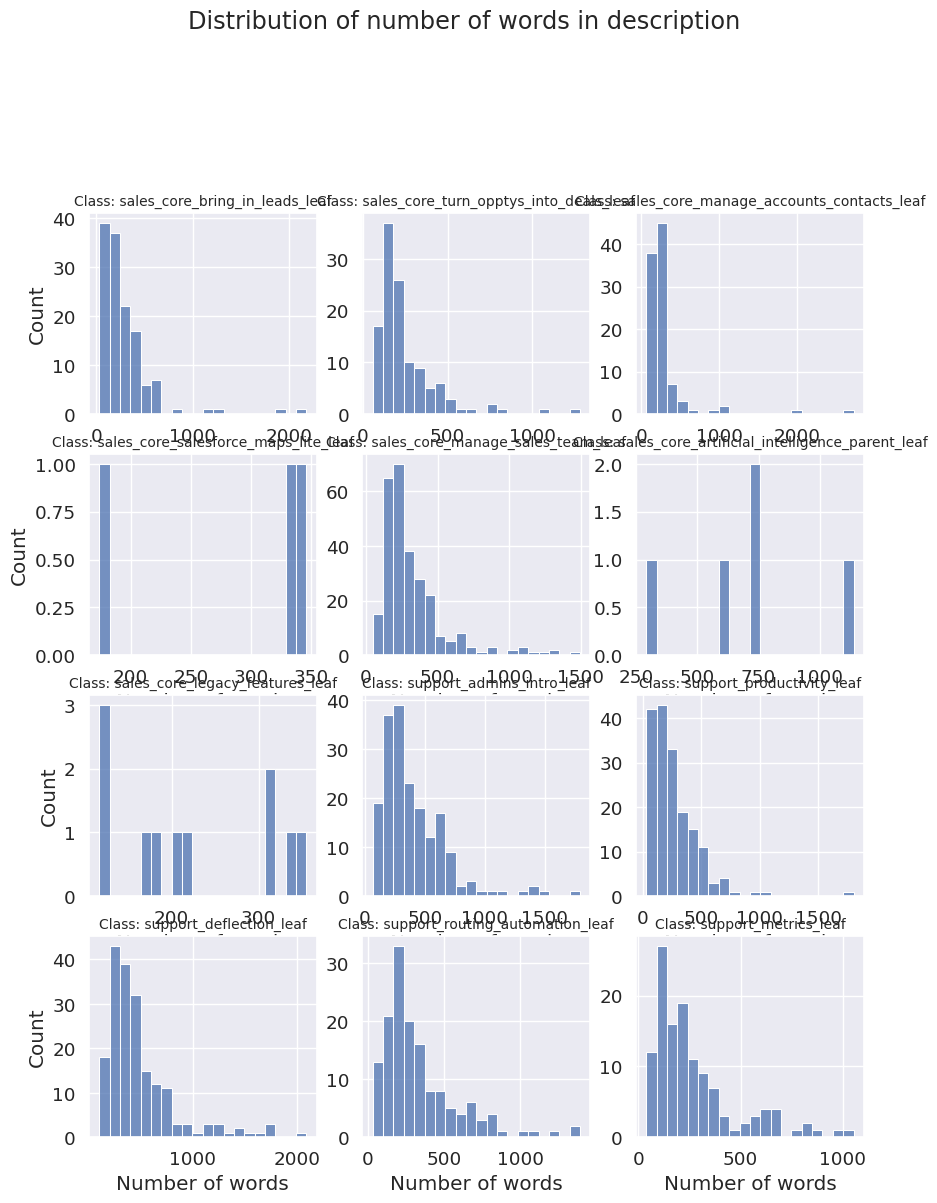

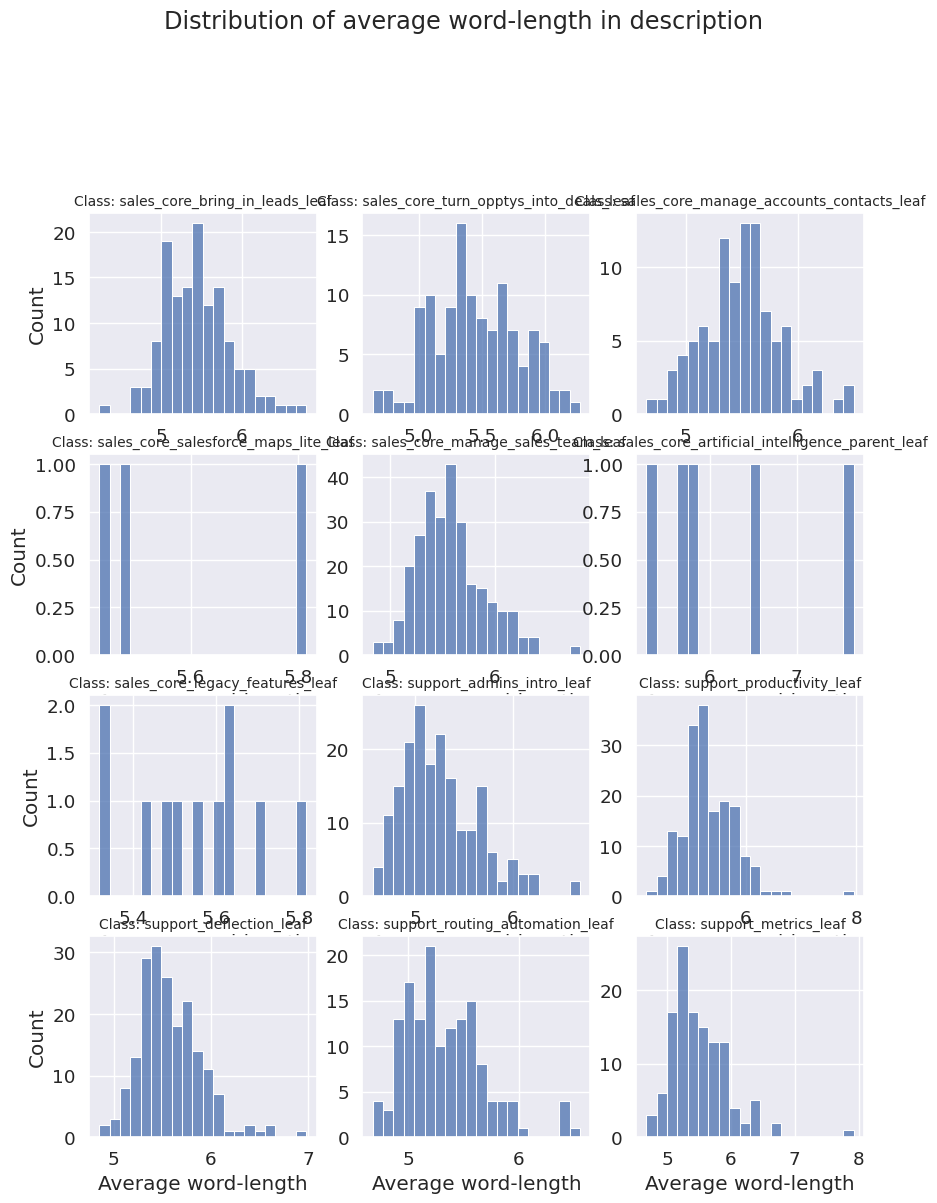

In [ ]:
# Distribution of number of characters in description
viz_class_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of characters in description
viz_char_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_frequency(data_by_label, label_dict = inverted_label_dict)
# Distribution of number of words in description
viz_word_length_frequency(data_by_label, label_dict = inverted_label_dict)

Size of the training set: 1176
Size of the validation set: 147
Size of the test set: 147


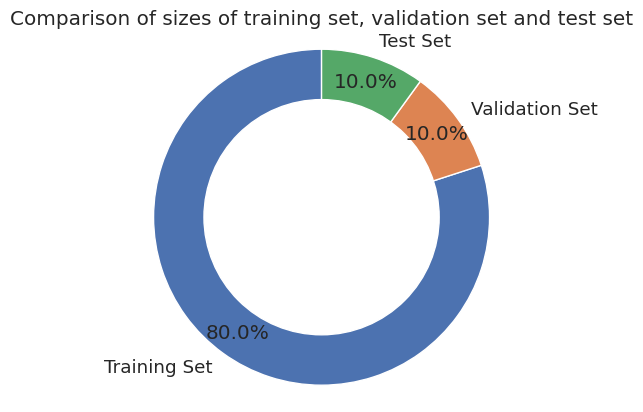

In [ ]:
# Feature-target split
data_train, data_val, data_test = training_test_split(data, test_size = 0.2)

In [ ]:
%%time
# Apply text normalization
data_train_norm, data_val_norm, data_test_norm = apply_text_normalizer(data_train, data_val, data_test)
# Display normalized training data
data_train_norm

CPU times: user 59 s, sys: 217 ms, total: 59.2 s
Wall time: 1min 16s


,normalized text,label
1003,create work plan template work plan management...,8
654,set manage case service cloud backbone service...,7
693,field email action case create email action ca...,7
643,add sale navigator lead contact account page l...,6
34,add campaign member manage member learn succes...,0
...,...,...
541,prepare sale management report unlock detail a...,4
968,broadcast site banner broadcast site banner le...,8
295,consideration use account salesforce keep cons...,2
666,permission set case feed case feed organizatio...,7


In [ ]:
# Vectorize
X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test = tfid_vectorizer(data_train_norm, data_val_norm, data_test_norm)
# Baseline
tfid_baseline(X_train_tfidf, y_train, X_val_tfidf, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



,Classifier,Training accuracy,Validation accuracy
3,Linear SVM,0.982993,0.972789
6,Ridge Classifier,0.986395,0.965986
5,SGD Classifier,0.998299,0.952381
0,Logistic Regression,0.969388,0.931973
4,Random Forest,1.000000,0.931973
7,XGBoost,1.000000,0.911565
2,Decision Tree,1.000000,0.829932
1,KNN Classifier,0.781463,0.802721
8,AdaBoost,0.278061,0.306122


In [ ]:
# Hyperparameter tuning for linear SVM
best_model_tfidf, best_params_tfidf, best_score_tfidf = tfid_svm_hyper_param_tune(X_train_tfidf, y_train, X_val_tfidf, y_val)

Gridpoint #1: {'C': 0.1, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.8962585034013606, Validation accuracy: 0.891156462585034, Runtime: 0m10s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9829931972789115, Validation accuracy: 0.9727891156462585, Runtime: 0m6s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9982993197278912, Validation accuracy: 0.9659863945578231, Runtime: 0m9s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9991496598639455, Validation accuracy: 0.9659863945578231, Runtime: 0m5s
 
Best model: SVC(C=1, kernel='linear', probability=True)
 
Best parameters: {'C': 1, 'kernel': 'linear', 'probability': True}
Best validation accuracy: 0.9727891156462585


Shape of the training set: (1176, 3837)
Shape of the test set: (147, 3837)

Size of the training labels: 1176
Size of the test labels: 147

Size of the test label predictions: 147

Test accuracy    0.965986
 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00        14
           2       1.00      0.93      0.96        14
           3       0.00      0.00      0.00         2
           4       1.00      1.00      1.00        27
           7       0.91      1.00      0.95        21
           8       1.00      0.88      0.94        17
           9       1.00      1.00      1.00        18
          10       0.94      1.00      0.97        16
          11       0.89      1.00      0.94         8

    accuracy                           0.97       147
   macro avg       0.87      0.88      0.87       147
weighted avg       0.96      0.97      0.96       147

 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



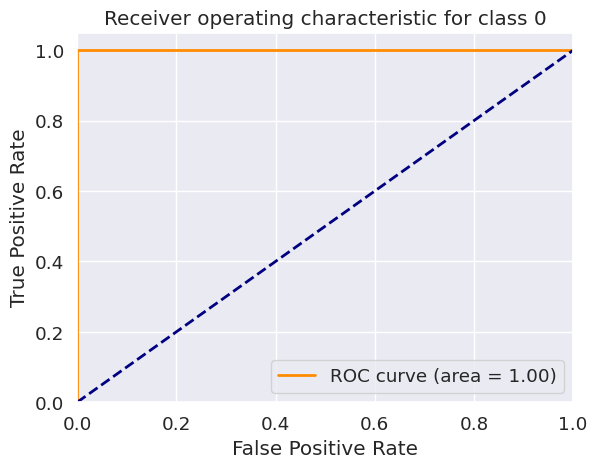

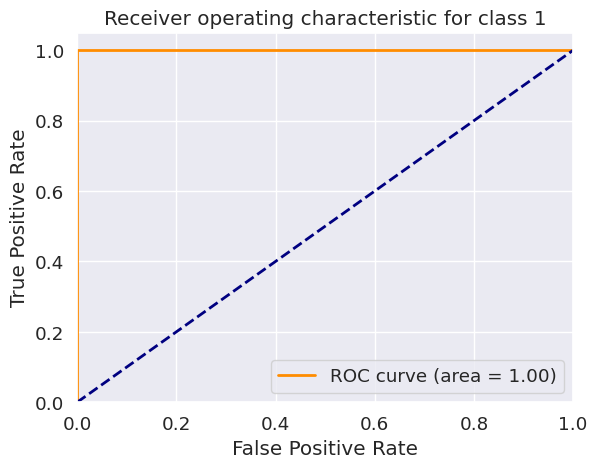

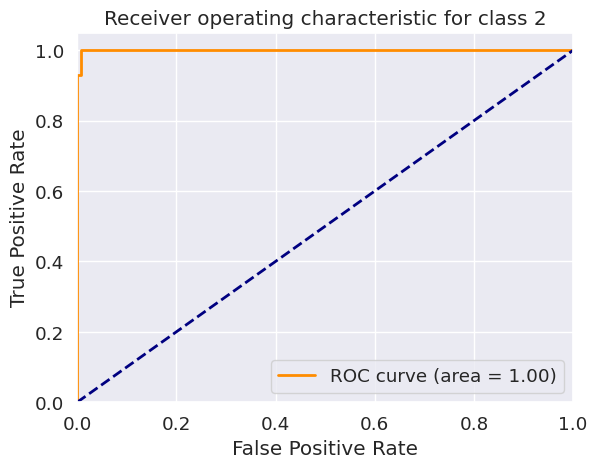

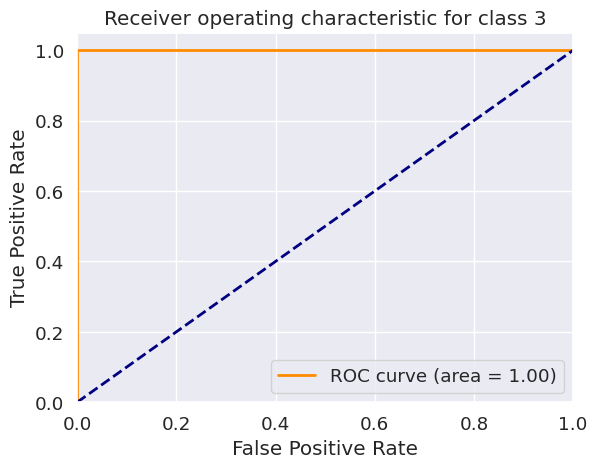

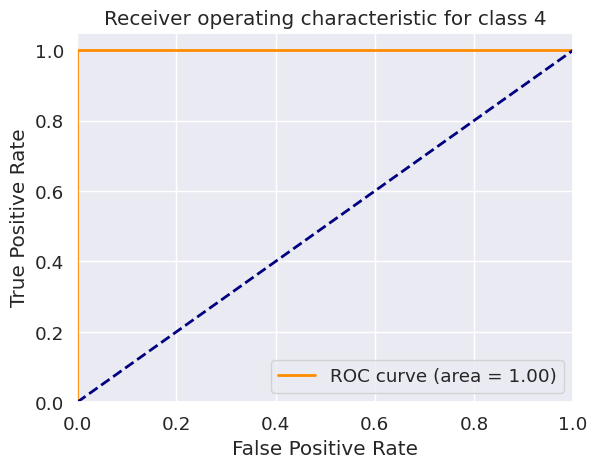

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



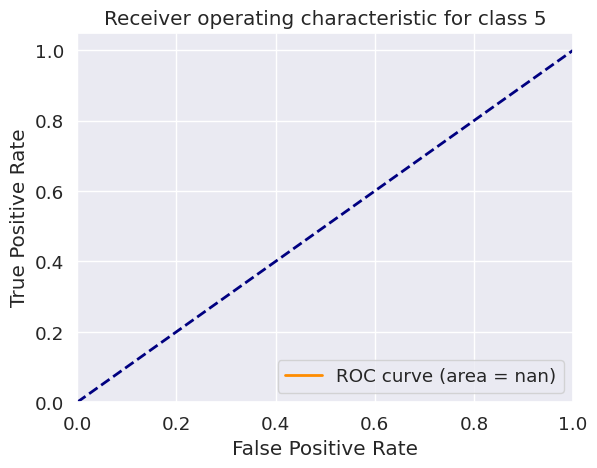

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless



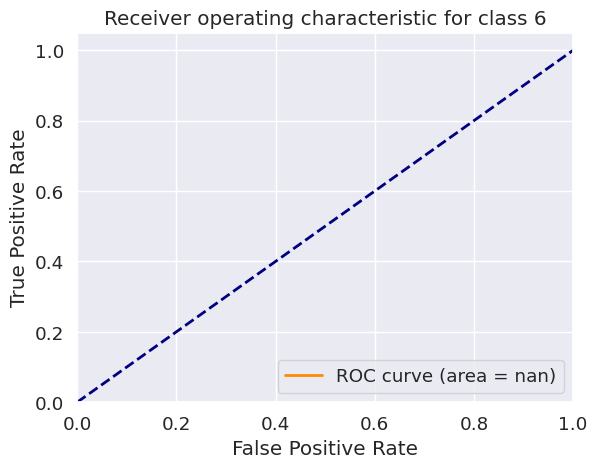

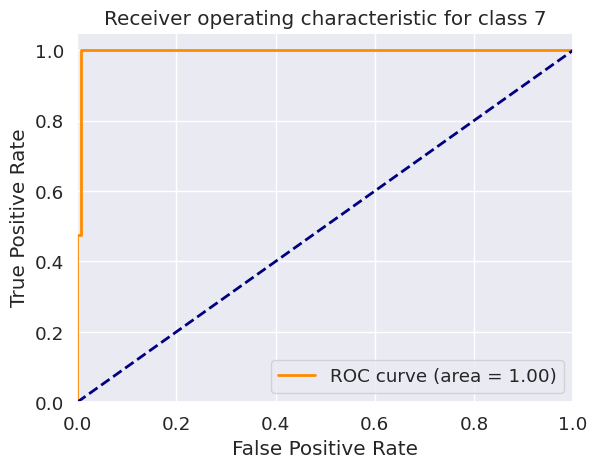

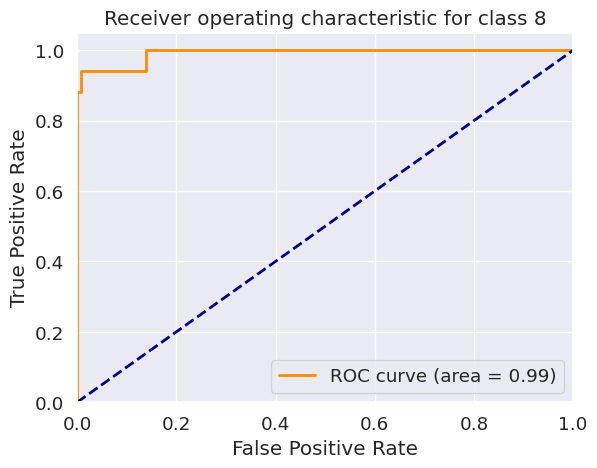

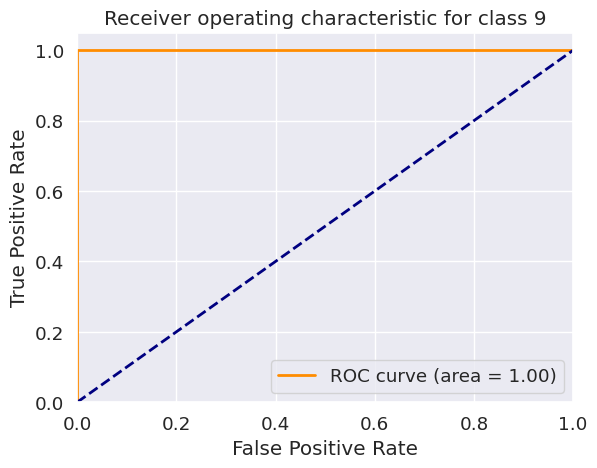

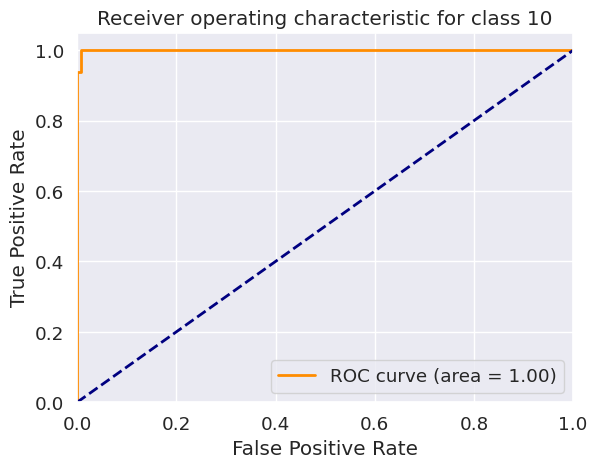

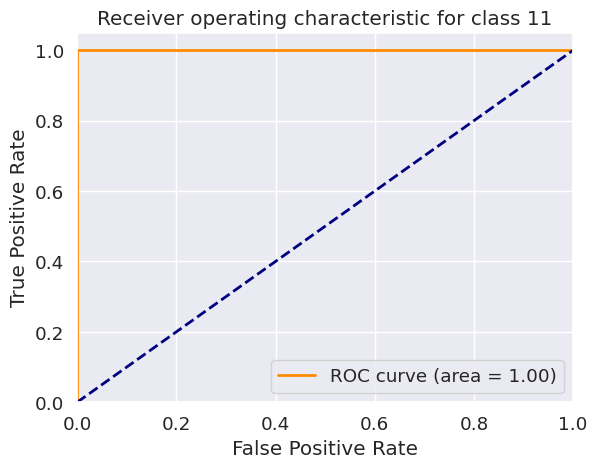

In [ ]:
# Prediction and evaluation on test set
best_model, X_train_vec, X_test_vec = best_model_tfidf, X_train_tfidf, X_test_tfidf
y_test_pred = run_best_model(best_model, X_train_vec, X_test_vec, y_train, y_test)

# Generate score analysis report
generate_score_analysis(X_test_vec, y_test, y_test_pred)

#Display Confusion Matrix
conf_mat(y_test, y_test_pred, figsize=(10, 8), font_scale=1.2, annot_kws_size=16)

In [ ]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         1933.50 seconds
Process memory usage          968.77 MB


## Rerun Process L2


 -------------------
 --  SCOPE DATA  --
 ------------------- 

Dropping records belonging to labels with 4 or fewer records: ['account_plans_leaf', 'conversation_transcript_access_leaf', 'contact_request_leaf', 'msj_intro_leaf', 'console_lex_service_setup_leaf', 'support_help_center_leaf', 'sales_core_salesforce_maps_lite_considerations_leaf', 'sales_core_salesforce_maps_lite_turn_on_leaf', 'support_omni_pointer_leaf', 'sales_core_salesforce_maps_lite_latitude_longitude_leaf', 'support_data_cloud_leaf', 'omnichannel_einstein_case_routing_leaf', 'support_communities_leaf', 'support_console_leaf', 'sales_einstein_features_data_usage_leaf', 'sales_ai_for_all_setup_overview_leaf', 'sales_ai_for_all_setup_manage_users_leaf', 'ise_service_innovations_from_industries_leaf', 'einstein_copilot_for_sales_leaf', 'scm_overview_leaf', 'sales_core_artificial_intelligence_leaf']
Memory usage       0.07 MB
Dataset shape    (1438, 5)
Columns in table: ['id', 'label', 'text', 'title', 'url']
label_dic

<ipython-input-181-fdb4b54be357>:32: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,id,label,text,title,url
0,campaigns_def_leaf,0,Get to Know Salesforce Campaigns Many cross-fu...,Get to Know Salesforce Campaigns,https://help.salesforce.com/s/articleView?id=s...
1,campaigns_tour_leaf,0,Tour the Campaigns Object To get familiar with...,Tour the Campaigns Object,https://help.salesforce.com/s/articleView?id=s...
2,campaigns_use_cases_leaf,0,How Campaigns Can Help You can use Salesforce ...,How Campaigns Can Help,https://help.salesforce.com/s/articleView?id=s...
3,campaigns_use_cases_other_clouds_leaf,0,Use Campaigns with Other Clouds For a more com...,Use Campaigns with Other Clouds,https://help.salesforce.com/s/articleView?id=s...
4,campaigns_hierarchy_leaf,0,Understand Campaign Hierarchy To organize and ...,Understand Campaign Hierarchy,https://help.salesforce.com/s/articleView?id=s...



Summary of data by labels:



,label,record_count
0,0,16
1,1,6
2,2,8
3,3,28
4,4,14
5,5,12
6,6,49
7,7,26
8,8,30
9,9,31



 ---------------------------------------
 --  TRAINING-VALIDATION-TEST-SPLIT  --
 --------------------------------------- 

Size of the training set: 1150
Size of the validation set: 144
Size of the test set: 144

Labels in training set: 41
Labels in validation set: 39
Labels in test set: 36

Columns in test set: Index(['id', 'text', 'title', 'url', 'label'], dtype='object')



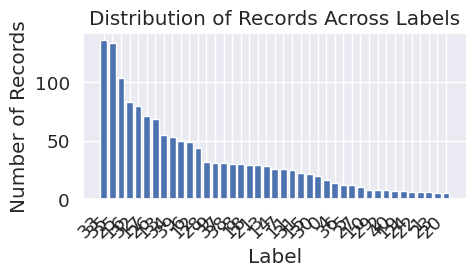

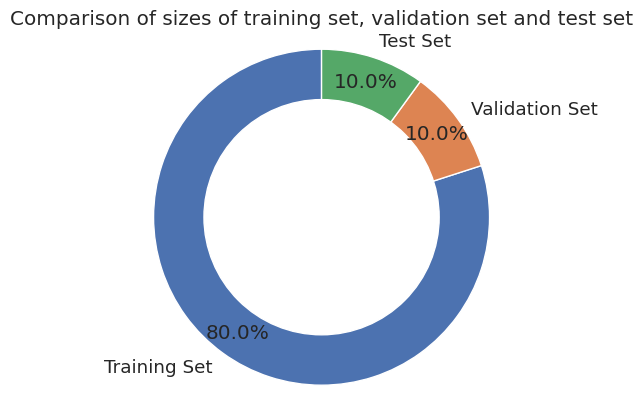


 ---------------------------
 --  TEXT NORMALIZATION  --
 --------------------------- 

Size of the training set: 1150
Size of the validation set: 144
Size of the test set: 144

Labels in training set: 41
Labels in validation set: 39
Labels in test set: 36

Columns in test set [normalized]: Index(['normalized text', 'label'], dtype='object')
Columns in test set [data]: Index(['id', 'text', 'title', 'url', 'label', 'normalized text'], dtype='object')

Sample of test set [normalized]:



,normalized text,label
90,lead buyer buyer assistant bot include automat...,6
1132,add network datum category page beta quickly a...,33
772,automatically add case email experience entitl...,26



Sample of test set [data]:



,id,text,title,url,label,normalized text
90,leads_sales_bots_lead_gen_leaf,Generate Leads with Buyer Assistant Buyer Assi...,Generate Leads with Buyer Assistant,https://help.salesforce.com/s/articleView?id=s...,6,lead buyer buyer assistant bot include automat...
1132,categories_add_network_data_category_object_pa...,Add the Network Data Category Object Page (Bet...,Add the Network Data Category Object Page (Beta),https://help.salesforce.com/s/articleView?id=s...,33,add network datum category page beta quickly a...
772,entitlements_auto_add_leaf,Automatically Add Entitlements to Cases from W...,Auto-Add Entitlements to Cases,https://help.salesforce.com/s/articleView?id=s...,26,automatically add case email experience entitl...




Sample of normalized training data:



,normalized text,label
90,lead buyer buyer assistant bot include automat...,6
1132,add network datum category page beta quickly a...,33
772,automatically add case email experience entitl...,26
1460,manage case service view manage employee case ...,39
733,send reply salesforce case feed use feature ca...,25



 ------------------------
 --  TF-IDF BASELINE  --
 ------------------------ 


Shape of the training set: (1150, 3701)
Shape of the validation set: (144, 3701)
Shape of the test set: (144, 3701)

Size of the training labels: 1150
Size of the validation labels: 144
Size of the test labels: 144



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



,Classifier,Training accuracy,Validation accuracy
3,Linear SVM,0.975652,0.986111
5,SGD Classifier,0.996522,0.979167
6,Ridge Classifier,0.980000,0.979167
0,Logistic Regression,0.941739,0.951389
4,Random Forest,1.000000,0.930556
7,XGBoost,1.000000,0.930556
2,Decision Tree,1.000000,0.854167
1,KNN Classifier,0.625217,0.666667
8,AdaBoost,0.237391,0.229167



 -------------------------------------
 --  TF-IDF HYPERPARAMETER TUNING  --
 ------------------------------------- 

Gridpoint #1: {'C': 0.1, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.7721739130434783, Validation accuracy: 0.7847222222222222, Runtime: 0m8s
 
Gridpoint #2: {'C': 1, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9756521739130435, Validation accuracy: 0.9861111111111112, Runtime: 0m8s
 
Gridpoint #3: {'C': 10, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9982608695652174, Validation accuracy: 0.9861111111111112, Runtime: 0m6s
 
Gridpoint #4: {'C': 100, 'kernel': 'linear', 'probability': True}
Training accuracy: 0.9991304347826087, Validation accuracy: 0.9861111111111112, Runtime: 0m5s
 
Best model: SVC(C=1, kernel='linear', probability=True)
 
Best parameters: {'C': 1, 'kernel': 'linear', 'probability': True}
Best validation accuracy: 0.9861111111111112

 ----------------------------------------
 --  FINAL PREDICTION A

,id,text,title,url,label,normalized text,label text,actual label,predicted label,predicted probability,predicted probability label,custom predicted label,basic accuracy,custom accuracy
791,entitlements_milestone_sequential_recurrence_leaf,Milestone Recurrence Types When you create a m...,Recurrence Types,https://help.salesforce.com/s/articleView?id=s...,26,milestone recurrence type create milestone cho...,support_service_level_agreements_leaf,26,26,0.501141,26,-1,1,0
388,pipeline_inspection_setup_rollups_leaf,Select a Forecast Rollups Method in Pipeline I...,Select a Forecast Rollups Method in Pipeline I...,https://help.salesforce.com/s/articleView?id=s...,15,forecast rollup pipeline inspection choose met...,pipeline_inspection_leaf,15,15,0.307603,16,-1,1,0
505,tm2_enable_tm2_leaf,Enable Sales Territories Start the process for...,Enable Sales Territories,https://help.salesforce.com/s/articleView?id=s...,17,sale start process manage territory distribute...,tm2_intro_leaf,17,17,0.841217,17,17,1,1


Test accuracy    0.951389
 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         1
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       1.00      0.50      0.67         4
          15       0.67      1.00      0.80         2
          16       0.92      0.92      0.92        12
          17       1.00      1.00      1.00        10

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning:

No positive samples in y_true, true positive value should be meaningless

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning:

No positive sa

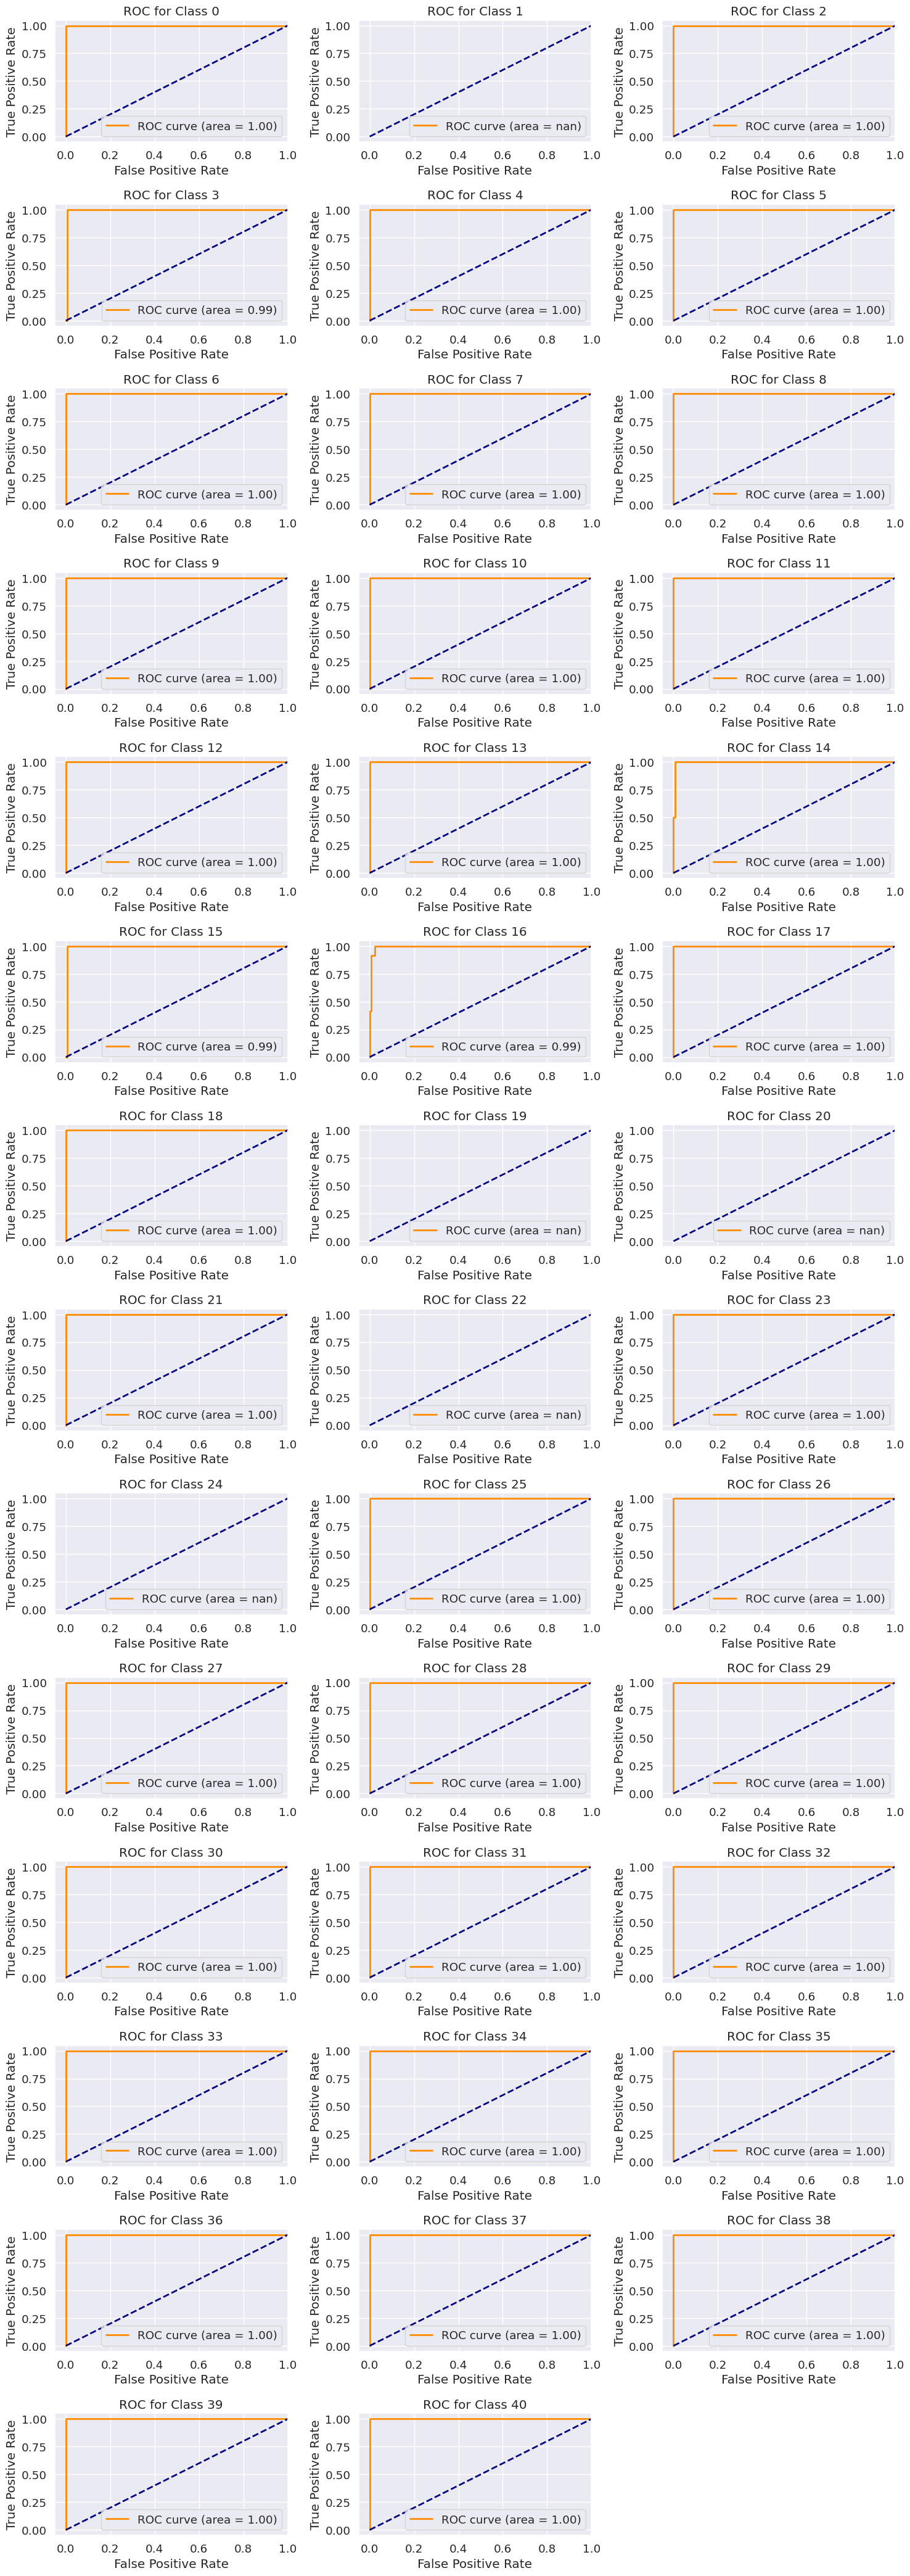

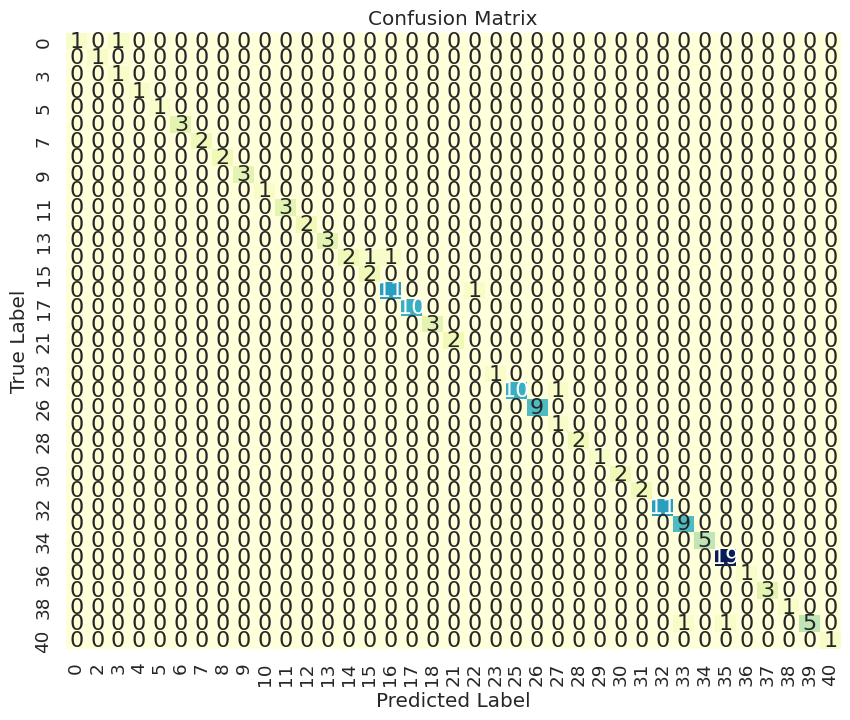



Error Summary with Percentage:


,label text,actual label,predicted label,error count,error percentage
0,automation_rules_queues_parent_leaf,36,36,1,1.754386
1,campaign_influence_parent_leaf,4,4,1,1.754386
2,campaigns_def_leaf,0,0,1,1.754386
3,campaigns_def_leaf,0,3,1,1.754386
4,campaigns_landing_page_leaf,2,2,1,1.754386
5,campaigns_members_landing_page_leaf,3,3,1,1.754386
6,campaigns_pardot_alignment_parent_leaf,5,5,1,1.754386
7,cases_intro_leaf,25,25,1,1.754386
8,cases_intro_leaf,25,27,1,1.754386
9,contacts_overview_leaf,13,13,1,1.754386


,id,text,title,url,label,normalized text,label text,actual label,predicted label,predicted probability,predicted probability label,custom predicted label,basic accuracy,custom accuracy
791,entitlements_milestone_sequential_recurrence_leaf,Milestone Recurrence Types When you create a m...,Recurrence Types,https://help.salesforce.com/s/articleView?id=s...,26,milestone recurrence type create milestone cho...,support_service_level_agreements_leaf,26,26,0.501141,26,-1,1,0
388,pipeline_inspection_setup_rollups_leaf,Select a Forecast Rollups Method in Pipeline I...,Select a Forecast Rollups Method in Pipeline I...,https://help.salesforce.com/s/articleView?id=s...,15,forecast rollup pipeline inspection choose met...,pipeline_inspection_leaf,15,15,0.307603,16,-1,1,0
738,case_interaction_rich_text_editor_leaf,Customize Emails with the Rich Text Editor in ...,Customize with Rich Text,https://help.salesforce.com/s/articleView?id=s...,25,customize email text editor salesforce case fe...,cases_intro_leaf,25,27,0.330558,25,-1,0,0
217,quotes_fields_leaf,Quotes Fields If you’re troubleshooting quotes...,Quotes Fields,https://help.salesforce.com/s/articleView?id=s...,9,field troubleshooting work custom field review...,quotes_overview_leaf,9,9,0.434148,9,-1,1,0
221,customize_contract_leaf,Set Up Contracts Customize Salesforce to handl...,Set Up Contracts,https://help.salesforce.com/s/articleView?id=s...,10,set contract salesforce handle contract manage...,contract_def_leaf,10,10,0.247906,10,-1,1,0
420,forecasts3_prm_setup_leaf,Enable Partner Portal Users to Add Opportuniti...,Enable Partner Portal Users to Add Opportuniti...,https://help.salesforce.com/s/articleView?id=s...,16,partner user add opportunity forecast sale tea...,forecasts3_intro_leaf,16,22,0.194073,16,-1,0,0
1365,service_intelligence_insights_setup_leaf,Enable the Propensity to Escalate Insight Comp...,Enable the Propensity to Escalate Insight Comp...,https://help.salesforce.com/s/articleView?id=s...,37,propensity escalate component propensity escal...,service_intelligence_intro_leaf,37,37,0.137208,37,-1,1,0
380,Acct_disc_use_leaf,Use Einstein Account Management Einstein Accou...,Use Einstein Account Management,https://help.salesforce.com/s/articleView?id=s...,14,use einstein account management einstein accou...,revenue_intelligence_leaf,14,14,0.343890,14,-1,1,0
645,sc_linkedin_sales_navigator_send_inmail_and_cr...,Send LinkedIn InMail and Connection Requests f...,Send LinkedIn InMail and Connection Requests f...,https://help.salesforce.com/s/articleView?id=s...,23,send linkedin inmail connection request salesf...,sc_linkedin_sales_navigator_leaf,23,23,0.128095,23,-1,1,0
73,campaigns_pardot_alignment_new_leaf,Get Started with Connected Campaigns If you pu...,Get Started with Connected Campaigns,https://help.salesforce.com/s/articleView?id=s...,5,get start connected campaign purchase account ...,campaigns_pardot_alignment_parent_leaf,5,5,0.434174,5,-1,1,0


In [ ]:
run_full_proj(data, scope = 'l2_id')

# 11.&nbsp; Conclusions

## Results Summary

## Model Comparison

## Concluding Observations

## Future Work

# 12.&nbsp; References

**Data Source**
- [1] Salesforce Help: Service Cloud, https://help.salesforce.com/s/articleView?id=sf.service_cloud.htm&type=5
- [2] Salesforce Help: Sales Cloud Basics, https://help.salesforce.com/s/articleView?id=sf.sales_core.htm&language=en_US&type=5

**Scrapign Script**
- [3] Thomas Bohn, sfdc_help_site_scrape.ipynb, https://github.com/TOM-BOHN/MsDS-supervised-nlp-sfdc-auto-classification/blob/main/sfdc_help_site_scrape.ipynb

**Documentation and References**
- [4] Lemmatization, https://en.wikipedia.org/wiki/Lemmatization
- [5] Natural Language Toolkit (NLTK), https://www.nltk.org/index.html
- [6] sklearn.feature_extraction.text.TfidfVectorizer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
- [7] sklearn.feature_extraction.text.TfidfTransformer, https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#
- [8] sklearn.ensemble.RandomForestClassifier, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
